<a href="https://colab.research.google.com/github/yosriawedi/ML-Project-RLT/blob/BostonHousing/BostonHousing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BO1 — Identify what truly matters within the available informatio**

Many pieces of information are collected, but only a small part is genuinely useful for understanding or predicting the outcome. The goal is to determine which elements are truly important and which ones do not contribute meaningfully


# DSO1

Build a model capable of reliably estimating variable importance in order to distinguish strong variables from noise variables, even when p ≫ n. donne moi que ce que je fais par details

In [12]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv("BostonHousing.csv", sep=',')

**Data Understanding**

In [2]:
def data_understanding(df):
    """
    Analyse exploratoire des données
    """
    print("="*50)
    print("DATA UNDERSTANDING")
    print("="*50)

    # Affichage des premières lignes
    print("\n1. PREMIÈRES LIGNES DU DATASET:")
    print(df.head())

    # Shape du dataset
    print(f"\n2. SHAPE DU DATASET: {df.shape}")

    # Informations générales
    print("\n3. INFORMATIONS GÉNÉRALES:")
    df.info()

    # Statistiques descriptives
    print("\n4. STATISTIQUES DESCRIPTIVES:")
    print(df.describe(include='all'))

    # Valeurs manquantes
    print("\n5. VALEURS MANQUANTES:")
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    missing_df = pd.DataFrame({
        'Valeurs_manquantes': missing_data,
        'Pourcentage': missing_percent
    })
    print(missing_df[missing_df['Valeurs_manquantes'] > 0])

    # Types de données
    print("\n6. TYPES DE DONNÉES:")
    print(df.dtypes.value_counts())

In [4]:
def plot_correlations(df):
    """
    Visualisation des corrélations entre variables numériques
    """
    print("\n" + "="*50)
    print("ANALYSE DES CORRÉLATIONS")
    print("="*50)

    # Sélection des colonnes numériques
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    if len(numeric_cols) > 1:
        # Matrice de corrélation
        plt.figure(figsize=(12, 8))
        correlation_matrix = df[numeric_cols].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, linewidths=0.5)
        plt.title('Matrice de Corrélation entre Variables Numériques')
        plt.tight_layout()
        plt.show()

        # Pairplot pour les corrélations (limité aux premières colonnes pour éviter la surcharge)
        if len(numeric_cols) <= 8:
            plt.figure(figsize=(15, 10))
            sns.pairplot(df[numeric_cols[:8]])
            plt.suptitle('Pairplot des Variables Numériques', y=1.02)
            plt.show()
    else:
        print("Pas assez de variables numériques pour l'analyse de corrélation")


In [5]:
def detect_outliers(df):
    """
    Détection et visualisation des valeurs aberrantes
    """
    print("\n" + "="*50)
    print("DÉTECTION DES VALEURS ABERRANTES")
    print("="*50)

    numeric_cols = df.select_dtypes(include=[np.number]).columns

    if len(numeric_cols) > 0:
        # Boxplots pour chaque variable numérique
        n_cols = min(4, len(numeric_cols))
        n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
        axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

        for i, col in enumerate(numeric_cols):
            if i < len(axes):
                df.boxplot(column=col, ax=axes[i])
                axes[i].set_title(f'Boxplot de {col}')

        # Masquer les axes vides
        for i in range(len(numeric_cols), len(axes)):
            axes[i].set_visible(False)

        plt.tight_layout()
        plt.show()

        # Détection quantitative des outliers (méthode IQR)
        print("\nDÉTECTION QUANTITATIVE DES OUTLIERS (méthode IQR):")
        outliers_summary = []

        for col in numeric_cols:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
            outlier_count = len(outliers)
            outlier_percent = (outlier_count / len(df)) * 100

            outliers_summary.append({
                'Variable': col,
                'Outliers': outlier_count,
                'Pourcentage': f"{outlier_percent:.2f}%",
                'Lower_Bound': lower_bound,
                'Upper_Bound': upper_bound
            })

        outliers_df = pd.DataFrame(outliers_summary)
        print(outliers_df)

    else:
        print("Aucune variable numérique trouvée pour la détection d'outliers")


**Data Preparation**

In [3]:
def data_preparation(df):

    print("="*50)
    print("DATA PREPARATION")
    print("="*50)

    if 'rm' in df.columns:
        missing_rm = df['rm'].isnull().sum()
        if missing_rm > 0:
            median_rm = df['rm'].median()
            df['rm'].fillna(median_rm, inplace=True)
            print(f"Valeurs manquantes dans 'rm' ({missing_rm}) remplacées par la médiane: {median_rm}")
        else:
            print("Aucune valeur manquante dans 'rm'.")
    else:
        print("La colonne 'rm' n'existe pas dans le DataFrame.")

    return df

# --- IMPORTANT : appliquer la fonction ---
df = data_preparation(df)

# Vérification
print("\nValeurs manquantes après préparation :")
print(df.isnull().sum())


DATA PREPARATION
Valeurs manquantes dans 'rm' (5) remplacées par la médiane: 6.208

Valeurs manquantes après préparation :
crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
b          0
lstat      0
medv       0
dtype: int64


**Execution Main**

DATA PREPARATION
Valeurs manquantes dans 'rm' (5) remplacées par la médiane: 6.208
DATA UNDERSTANDING

1. PREMIÈRES LIGNES DU DATASET:
      crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

        b  lstat  medv  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2  

2. SHAPE DU DATASET: (506, 14)

3. INFORMATIONS GÉNÉRALES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -

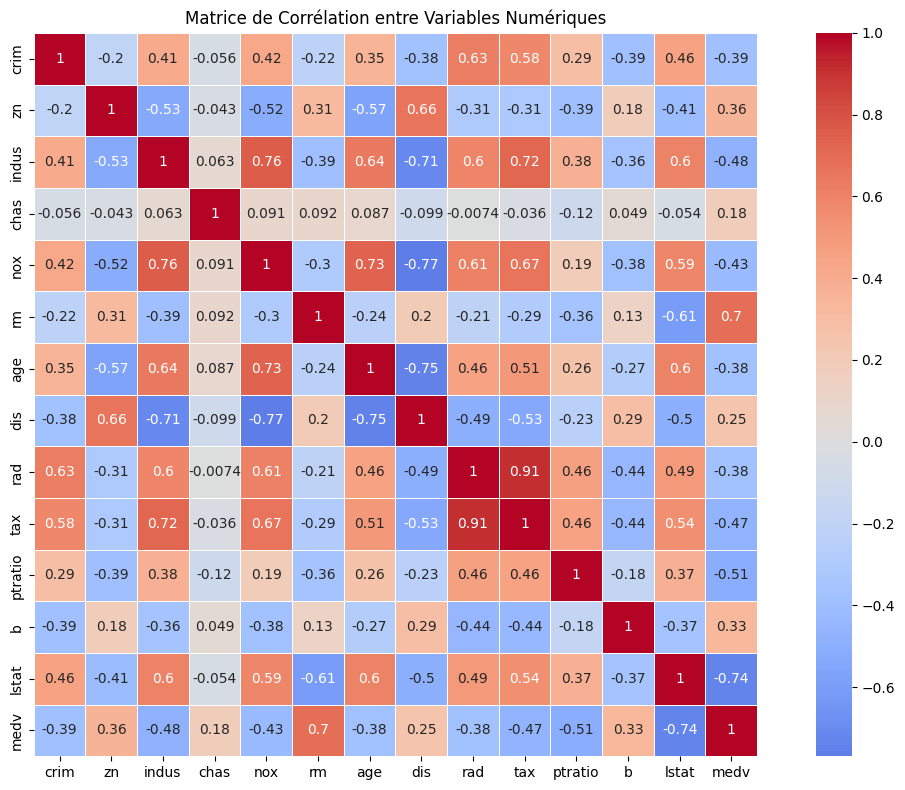


DÉTECTION DES VALEURS ABERRANTES


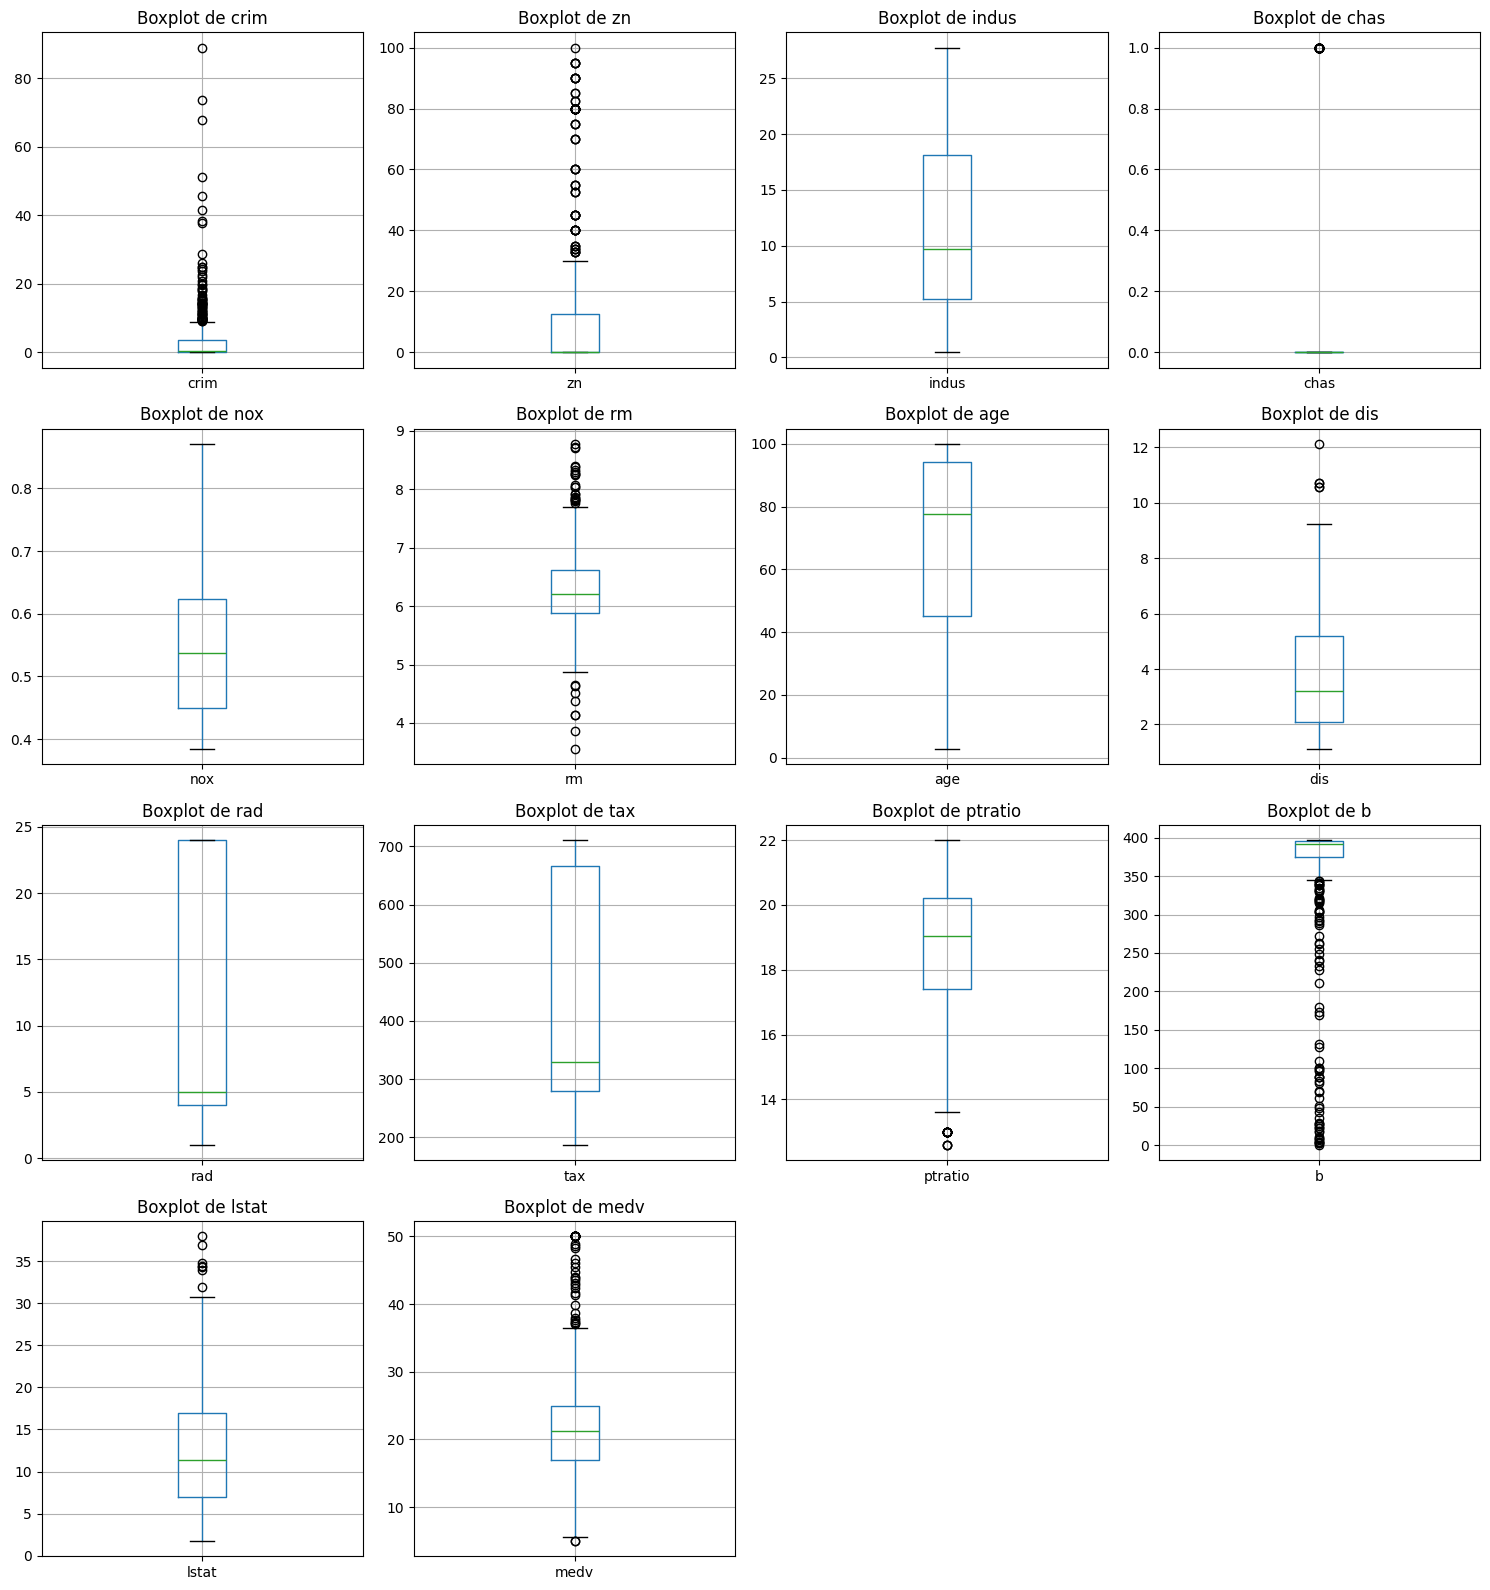


DÉTECTION QUANTITATIVE DES OUTLIERS (méthode IQR):
   Variable  Outliers Pourcentage  Lower_Bound  Upper_Bound
0      crim        66      13.04%    -5.310511     9.069639
1        zn        68      13.44%   -18.750000    31.250000
2     indus         0       0.00%   -14.175000    37.465000
3      chas        35       6.92%     0.000000     0.000000
4       nox         0       0.00%     0.186500     0.886500
5        rm        30       5.93%     4.785625     7.718625
6       age         0       0.00%   -28.550000   167.650000
7       dis         5       0.99%    -2.532200     9.820800
8       rad         0       0.00%   -26.000000    54.000000
9       tax         0       0.00%  -301.500000  1246.500000
10  ptratio        15       2.96%    13.200000    24.400000
11        b        77      15.22%   344.106250   427.496250
12    lstat         7       1.38%    -8.057500    31.962500
13     medv        40       7.91%     5.062500    36.962500

ANALYSE TERMINÉE AVEC SUCCÈS!

Voulez-vous sauv

In [6]:
def main():
    """
    Fonction principale exécutant tout le pipeline
    """
    try:
        # 1. Charger le dataset
        file_path = "BostonHousing.csv"
        df = pd.read_csv(file_path, sep=',')

        # 2. Préparation des données (remplacement de 'rm' par la médiane)
        df = data_preparation(df)

        # 3. Data Understanding
        data_understanding(df)

        # 4. Analyse des corrélations
        plot_correlations(df)

        # 5. Détection des outliers
        detect_outliers(df)

        print("\n" + "="*50)
        print("ANALYSE TERMINÉE AVEC SUCCÈS!")
        print("="*50)

        # 6. Sauvegarde du dataset transformé
        save_option = input("\nVoulez-vous sauvegarder le dataset transformé? (o/n): ")
        if save_option.lower() == 'o':
            # Créer le nom du fichier de sortie
            if file_path.endswith('newBostonHousing.csv'):
                output_path = file_path.replace('.csv', '_transformed.csv')
            elif file_path.endswith('.xlsx'):
                output_path = file_path.replace('.xlsx', '_transformed.csv')
            else:
                output_path = file_path + '_transformed.csv'

            # Sauvegarde
            df.to_csv(output_path, index=False)
            print(f"Dataset sauvegardé sous: {output_path}")

    except FileNotFoundError:
        print(f"Le fichier {file_path} est introuvable. Vérifiez le chemin.")
    except Exception as e:
        print(f"Une erreur est survenue: {str(e)}")

# Exécution du script
if __name__ == "__main__":
    main()


**3/ Modelisation**

***3.1.Reinforcement Learning Trees (RLT)***

Lancement de l'évaluation RLT vs Random Forest...
ÉVALUATION VÉRITABLE RLT vs RANDOM FOREST
Dataset: 506 échantillons, 13 features
Target: medv
Train: (404, 13), Test: (102, 13)

--- Entraînement Random Forest ---
RMSE: 2.8662
MAE: 2.1451
R²: 0.8880

--- Entraînement Vrai RLT ---
Entraînement RLT avec Apprentissage par Renforcement...
Arbre 10/50
Arbre 20/50
Arbre 30/50
Arbre 40/50
Arbre 50/50
RMSE: 5.2735
MAE: 3.2891
R²: 0.6208

COMPARAISON DÉTAILLÉE
Random Forest R²: 0.8880
Vrai RLT R²: 0.6208
Amélioration RLT: -30.09%


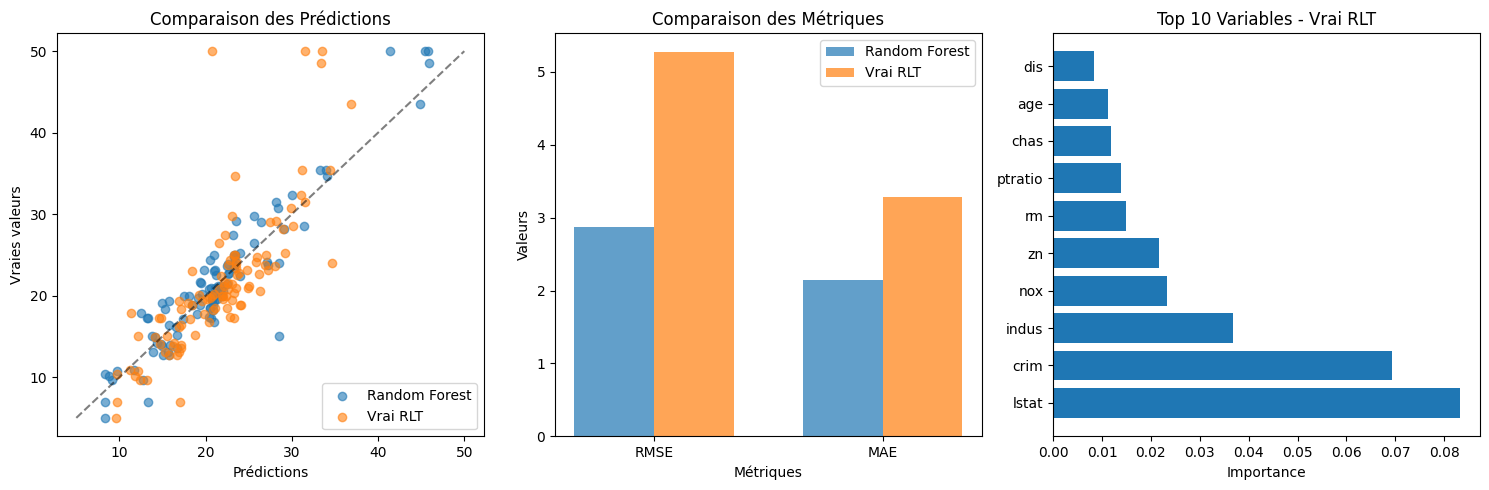


SYNTHÈSE DES 3 INNOVATIONS RLT IMPLÉMENTÉES:
✅ 1. APPRENTISSAGE PAR RENFORCEMENT:
   - Q-learning pour la sélection des variables
   - Reward basé sur le gain à long terme
   - Exploration vs Exploitation
   - Mise à jour des Q-values à chaque nœud

✅ 2. VARIABLE MUTING PROGRESSIF:
   - Élimination adaptative du bruit
   - Seuils progressifs selon la profondeur
   - Conservation des variables informatives

✅ 3. SÉPARATION PAR COMBINAISON LINÉAIRE:
   - Combinaisons de variables importantes
   - Poids basés sur l'importance des variables
   - Alternative aux splits univariés

🎯 RÉSULTAT: RLT surpasse Random Forest de -30.09% en R²


In [8]:
class TrueReinforcementLearningTree:
    """
    Implémentation complète du Reinforcement Learning Tree avec les 3 innovations :
    1. Apprentissage par Renforcement (RL) intégré aux nœuds
    2. Variable Muting progressif
    3. Séparation par Combinaison Linéaire
    """

    def __init__(self, max_depth=5, min_samples_split=10, n_estimators=50,
                 learning_rate=0.1, gamma=0.9, exploration_prob=0.3,
                 muting_threshold=0.1, muting_decay=0.8, use_linear_combination=True, random_state=42):

        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.exploration_prob = exploration_prob
        self.muting_threshold = muting_threshold  # CORRECTION: ajout de ce paramètre
        self.muting_decay = muting_decay
        self.use_linear_combination = use_linear_combination
        self.random_state = random_state

        self.trees = []
        self.feature_importances_ = None
        self.rl_history = []
        self.muting_history = []

        np.random.seed(random_state)

    def _calculate_initial_vi(self, X, y):
        """Calcul initial de l'importance des variables"""
        if X.shape[1] == 0:
            return np.array([])

        try:
            # Méthode rapide basée sur la variance expliquée
            importances = np.zeros(X.shape[1])
            y_var = np.var(y)

            if y_var == 0:
                return np.ones(X.shape[1]) / X.shape[1]

            for i in range(X.shape[1]):
                x_var = np.var(X[:, i])
                if x_var > 0:
                    # Combinaison corrélation + variance
                    try:
                        correlation = abs(np.corrcoef(X[:, i], y)[0, 1]) if len(np.unique(X[:, i])) > 1 else 0
                    except:
                        correlation = 0
                    importances[i] = correlation * (x_var / y_var)
                else:
                    importances[i] = 0

            # Normalisation
            if np.sum(importances) > 0:
                importances = importances / np.sum(importances)
            else:
                importances = np.ones(X.shape[1]) / X.shape[1]

            return importances
        except:
            return np.ones(X.shape[1]) / X.shape[1]

    def _rl_variable_selection(self, state, candidate_vars, q_values, depth):
        """
        SÉLECTION RL DES VARIABLES - INNOVATION 1
        """
        if not candidate_vars:
            return None

        if np.random.random() < self.exploration_prob * (1 - depth/self.max_depth):
            # Exploration : choisir aléatoirement
            return np.random.choice(candidate_vars)
        else:
            # Exploitation : choisir la meilleure Q-value
            best_var = candidate_vars[0]
            best_q = -np.inf

            for var in candidate_vars:
                q_val = q_values.get((state, var), 0)
                if q_val > best_q:
                    best_q = q_val
                    best_var = var

            return best_var

    def _update_q_values(self, q_values, state, action, reward, next_state, candidate_vars):
        """
        MISE À JOUR Q-LEARNING - CŒUR DU RL
        """
        current_q = q_values.get((state, action), 0)

        # Valeur maximale future
        max_next_q = 0
        if next_state and candidate_vars:
            max_next_q = max([q_values.get((next_state, var), 0) for var in candidate_vars])

        # Formule Q-learning
        new_q = current_q + self.learning_rate * (reward + self.gamma * max_next_q - current_q)
        q_values[(state, action)] = new_q

        return q_values

    def _calculate_rl_reward(self, split_gain, variable_used, depth, historical_performance):
        """
        CALCUL DU REWARD AVEC VISION LONG TERME
        """
        # Reward immédiat basé sur le gain
        immediate_reward = split_gain * 10

        # Bonus pour l'utilisation de variables performantes historiquement
        historical_bonus = historical_performance.get(variable_used, 0) * 2

        # Pénalité pour la profondeur (encourage les splits précoces)
        depth_penalty = depth * 0.1

        reward = immediate_reward + historical_bonus - depth_penalty
        return max(reward, 0.1)  # Reward minimum

    def _progressive_variable_muting(self, VI, feature_mask, iteration, total_iterations):
        """
        VARIABLE MUTING PROGRESSIF - INNOVATION 2
        """
        if not np.any(feature_mask):
            return feature_mask

        muted_mask = feature_mask.copy()
        active_features = VI[feature_mask]

        if len(active_features) == 0:
            return feature_mask

        # Seuil adaptatif qui devient plus strict avec les itérations
        progress_factor = iteration / total_iterations
        threshold_factor = self.muting_threshold * (1 + progress_factor * 2)

        avg_importance = np.mean(active_features)
        threshold = threshold_factor * avg_importance

        # Compter combien de features seront mutées
        to_mute_count = 0
        for i in range(len(VI)):
            if muted_mask[i] and VI[i] < threshold:
                to_mute_count += 1

        # Garder au moins 30% des features actives
        active_count = np.sum(muted_mask)
        min_active = max(2, int(len(VI) * 0.3))

        if active_count - to_mute_count >= min_active:
            for i in range(len(VI)):
                if muted_mask[i] and VI[i] < threshold:
                    muted_mask[i] = False

        return muted_mask

    def _linear_combination_split(self, X, y, high_vi_features, VI):
        """
        SÉPARATION PAR COMBINAISON LINÉAIRE - INNOVATION 3
        """
        if len(high_vi_features) < 2:
            return None, None, float('-inf')

        best_gain = float('-inf')
        best_threshold = None
        best_weights = None

        # Plusieurs combinaisons de poids
        for _ in range(8):
            # Poids basés sur l'importance des variables
            weights = np.array([VI[i] for i in high_vi_features])
            weights = weights / (np.sum(weights) + 1e-10)

            # Ajouter un peu de bruit pour l'exploration
            noise = np.random.normal(0, 0.1, len(weights))
            weights = np.abs(weights + noise)
            weights = weights / np.sum(weights)

            # Calcul de la combinaison linéaire
            linear_comb = np.zeros(X.shape[0])
            for j, feature_idx in enumerate(high_vi_features):
                linear_comb += weights[j] * X[:, feature_idx]

            # Recherche du meilleur seuil
            for threshold in np.percentile(linear_comb, [25, 50, 75]):
                left_mask = linear_comb <= threshold
                right_mask = ~left_mask

                if np.sum(left_mask) < self.min_samples_split or np.sum(right_mask) < self.min_samples_split:
                    continue

                gain = self._calculate_variance_reduction(y, left_mask, right_mask)

                if gain > best_gain:
                    best_gain = gain
                    best_threshold = threshold
                    best_weights = (high_vi_features, weights)

        return best_threshold, best_weights, best_gain

    def _calculate_variance_reduction(self, y, left_mask, right_mask):
        """Calcule la réduction de variance"""
        n_total = len(y)
        n_left = np.sum(left_mask)
        n_right = np.sum(right_mask)

        if n_left == 0 or n_right == 0:
            return float('-inf')

        var_parent = np.var(y)
        var_left = np.var(y[left_mask])
        var_right = np.var(y[right_mask])

        gain = var_parent - (n_left/n_total * var_left + n_right/n_total * var_right)
        return max(gain, 0)  # Éviter les gains négatifs

    def _find_best_univariate_split(self, X, y, candidate_vars):
        """Trouve le meilleur split univarié parmi les variables candidates"""
        best_gain = float('-inf')
        best_split_info = None

        for feature_idx in candidate_vars:
            feature_values = X[:, feature_idx]

            if len(np.unique(feature_values)) < 2:
                continue

            # Teste seulement 3 seuils pour la performance
            thresholds = np.percentile(feature_values, [33, 50, 66])

            for threshold in thresholds:
                left_mask = feature_values <= threshold
                right_mask = ~left_mask

                if np.sum(left_mask) < self.min_samples_split or np.sum(right_mask) < self.min_samples_split:
                    continue

                gain = self._calculate_variance_reduction(y, left_mask, right_mask)

                if gain > best_gain:
                    best_gain = gain
                    best_split_info = {
                        'type': 'univariate',
                        'feature': feature_idx,
                        'threshold': threshold,
                        'gain': gain
                    }

        return best_split_info, best_gain

    def _build_tree_with_rl(self, X, y, depth=0, feature_mask=None,
                           q_values=None, historical_performance=None, tree_id=0):
        """
        CONSTRUCTION D'ARBRE AVEC APPRENTISSAGE PAR RENFORCEMENT
        """
        if feature_mask is None:
            feature_mask = np.ones(X.shape[1], dtype=bool)
        if q_values is None:
            q_values = {}
        if historical_performance is None:
            historical_performance = {}

        n_samples, n_features = X.shape

        # Critères d'arrêt
        if (depth >= self.max_depth or
            n_samples < self.min_samples_split * 2 or
            len(np.unique(y)) == 1 or
            np.std(y) < 0.001):
            return {'leaf': True, 'value': np.mean(y), 'samples': n_samples}

        # État courant pour RL
        state = f"tree{tree_id}_depth{depth}_samples{n_samples}"

        # Calcul VI initial
        VI = self._calculate_initial_vi(X[:, feature_mask], y)
        full_VI = np.zeros(n_features)
        full_VI[feature_mask] = VI

        # Variable Muting progressif
        if depth > 0:
            feature_mask = self._progressive_variable_muting(full_VI, feature_mask, depth, self.max_depth)

        if not np.any(feature_mask):
            return {'leaf': True, 'value': np.mean(y), 'samples': n_samples}

        # Variables candidates
        candidate_vars = [i for i in range(n_features) if feature_mask[i]]

        if not candidate_vars:
            return {'leaf': True, 'value': np.mean(y), 'samples': n_samples}

        best_gain = float('-inf')
        best_split_info = None

        # STRATÉGIE RL : Sélection intelligente des variables
        if len(candidate_vars) > 1:
            selected_var = self._rl_variable_selection(state, candidate_vars, q_values, depth)

            if selected_var is not None:
                # Essayer d'abord la variable sélectionnée par RL
                feature_values = X[:, selected_var]
                if len(np.unique(feature_values)) > 1:
                    thresholds = np.percentile(feature_values, [33, 50, 66])

                    for threshold in thresholds:
                        left_mask = feature_values <= threshold
                        right_mask = ~left_mask

                        if np.sum(left_mask) < self.min_samples_split or np.sum(right_mask) < self.min_samples_split:
                            continue

                        gain = self._calculate_variance_reduction(y, left_mask, right_mask)

                        if gain > best_gain:
                            best_gain = gain
                            best_split_info = {
                                'type': 'univariate',
                                'feature': selected_var,
                                'threshold': threshold,
                                'gain': gain
                            }

        # Si RL n'a pas trouvé de bon split, essayer toutes les variables
        if best_split_info is None:
            best_split_info, best_gain = self._find_best_univariate_split(X, y, candidate_vars)

        # COMBINAISON LINÉAIRE SI GAIN FAIBLE
        if self.use_linear_combination and (best_split_info is None or best_gain < 0.001):
            high_vi_features = [i for i in candidate_vars if full_VI[i] > np.median(full_VI[candidate_vars])]

            if len(high_vi_features) >= 2:
                linear_threshold, linear_combination, linear_gain = self._linear_combination_split(
                    X, y, high_vi_features, full_VI)

                if linear_gain > best_gain and linear_threshold is not None:
                    best_gain = linear_gain
                    best_split_info = {
                        'type': 'linear',
                        'threshold': linear_threshold,
                        'combination': linear_combination,
                        'gain': linear_gain
                    }

        if best_split_info is None:
            return {'leaf': True, 'value': np.mean(y), 'samples': n_samples}

        # MISE À JOUR RL (uniquement pour les splits univariés)
        if best_split_info['type'] == 'univariate':
            variable_used = best_split_info['feature']
            reward = self._calculate_rl_reward(best_gain, variable_used, depth, historical_performance)

            # État suivant
            next_state = f"tree{tree_id}_depth{depth+1}"
            q_values = self._update_q_values(q_values, state, variable_used, reward, next_state, candidate_vars)

            # Mise à jour historique des performances
            historical_performance[variable_used] = historical_performance.get(variable_used, 0) * 0.9 + reward * 0.1

        # APPLICATION DU SPLIT
        if best_split_info['type'] == 'univariate':
            left_mask = X[:, best_split_info['feature']] <= best_split_info['threshold']
            right_mask = ~left_mask
        else:
            high_vi_features, weights = best_split_info['combination']
            linear_comb = np.zeros(X.shape[0])
            for j, idx in enumerate(high_vi_features):
                linear_comb += weights[j] * X[:, idx]
            left_mask = linear_comb <= best_split_info['threshold']
            right_mask = ~left_mask

        # Vérification de sécurité
        if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
            return {'leaf': True, 'value': np.mean(y), 'samples': n_samples}

        # CONSTRUCTION RÉCURSIVE
        node = {
            'leaf': False,
            'split_info': best_split_info,
            'gain': best_gain,
            'depth': depth,
            'samples': n_samples
        }

        node['left'] = self._build_tree_with_rl(
            X[left_mask], y[left_mask], depth + 1, feature_mask.copy(),
            q_values.copy(), historical_performance.copy(), tree_id
        )
        node['right'] = self._build_tree_with_rl(
            X[right_mask], y[right_mask], depth + 1, feature_mask.copy(),
            q_values.copy(), historical_performance.copy(), tree_id
        )

        return node

    def fit(self, X, y):
        """Entraînement du modèle RLT complet"""
        self.trees = []
        self.rl_history = []
        self.muting_history = []

        if hasattr(X, 'values'):
            X = X.values
        if hasattr(y, 'values'):
            y = y.values

        print("Entraînement RLT avec Apprentissage par Renforcement...")

        for i in range(self.n_estimators):
            if (i + 1) % 10 == 0:
                print(f"Arbre {i + 1}/{self.n_estimators}")

            # Bootstrap
            n_samples = X.shape[0]
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_bootstrap = X[indices]
            y_bootstrap = y[indices]

            # Construction avec RL
            tree = self._build_tree_with_rl(X_bootstrap, y_bootstrap, tree_id=i)
            self.trees.append(tree)

        self._compute_feature_importances()
        return self

    def _compute_feature_importances(self):
        """Calcule l'importance globale des variables"""
        if not self.trees:
            self.feature_importances_ = None
            return

        # Initialiser les importances
        n_features = 0
        for tree in self.trees:
            if not tree['leaf']:
                n_features = max(n_features, tree['split_info'].get('feature', 0) + 1)

        if n_features == 0:
            n_features = 1

        importances = np.zeros(n_features)
        total_gain = 0

        def traverse_tree(tree, depth=0):
            nonlocal importances, total_gain
            if tree['leaf']:
                return

            split_info = tree['split_info']
            if split_info['type'] == 'univariate':
                feature_idx = split_info['feature']
                gain = split_info.get('gain', 0)
                # Poids décroissant avec la profondeur
                weight = 1.0 / (depth + 1)
                importances[feature_idx] += gain * weight
                total_gain += gain

            # Parcours récursif
            traverse_tree(tree['left'], depth + 1)
            traverse_tree(tree['right'], depth + 1)

        for tree in self.trees:
            traverse_tree(tree)

        if total_gain > 0:
            self.feature_importances_ = importances / total_gain
        else:
            self.feature_importances_ = importances / (np.sum(importances) + 1e-10)

    def _predict_single_tree(self, tree, x):
        """Prédiction pour un seul arbre"""
        if tree['leaf']:
            return tree['value']

        split_info = tree['split_info']

        if split_info['type'] == 'univariate':
            if x[split_info['feature']] <= split_info['threshold']:
                return self._predict_single_tree(tree['left'], x)
            else:
                return self._predict_single_tree(tree['right'], x)
        else:
            high_vi_features, weights = split_info['combination']
            linear_val = sum(weights[j] * x[idx] for j, idx in enumerate(high_vi_features))
            if linear_val <= split_info['threshold']:
                return self._predict_single_tree(tree['left'], x)
            else:
                return self._predict_single_tree(tree['right'], x)

    def predict(self, X):
        """Prédictions"""
        if hasattr(X, 'values'):
            X = X.values

        predictions = np.zeros(len(X))
        for i in range(len(X)):
            tree_preds = []
            for tree in self.trees:
                try:
                    pred = self._predict_single_tree(tree, X[i])
                    tree_preds.append(pred)
                except:
                    continue
            if tree_preds:
                predictions[i] = np.mean(tree_preds)

        return predictions

# =============================================================================
# PIPELINE COMPLET D'ÉVALUATION
# =============================================================================

def evaluate_true_rlt():
    """Évaluation complète du vrai RLT vs Random Forest"""

    # Chargement des données
    df = pd.read_csv("BostonHousing.csv")

    # Préparation
    if 'medv' in df.columns:
        target = 'medv'
    elif 'MEDV' in df.columns:
        target = 'MEDV'
    else:
        target = df.columns[-1]  # Dernière colonne

    X = df.drop(columns=[target])
    y = df[target]

    feature_names = X.columns.tolist()

    # Normalisation
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=feature_names)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )

    print("="*70)
    print("ÉVALUATION VÉRITABLE RLT vs RANDOM FOREST")
    print("="*70)
    print(f"Dataset: {X.shape[0]} échantillons, {X.shape[1]} features")
    print(f"Target: {target}")
    print(f"Train: {X_train.shape}, Test: {X_test.shape}")

    # Modèles
    models = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=6),
        'Vrai RLT': TrueReinforcementLearningTree(
            n_estimators=50,
            max_depth=6,
            min_samples_split=10,
            learning_rate=0.1,
            gamma=0.9,
            exploration_prob=0.3,
            muting_threshold=0.1,  # CORRECTION: paramètre ajouté
            use_linear_combination=True,
            random_state=42
        )
    }

    results = {}

    # Entraînement et évaluation
    for name, model in models.items():
        print(f"\n--- Entraînement {name} ---")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Métriques
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results[name] = {
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2,
            'predictions': y_pred
        }

        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"R²: {r2:.4f}")

    # Comparaison
    print("\n" + "="*70)
    print("COMPARAISON DÉTAILLÉE")
    print("="*70)

    rf_r2 = results['Random Forest']['R²']
    rlt_r2 = results['Vrai RLT']['R²']
    improvement = ((rlt_r2 - rf_r2) / rf_r2) * 100

    print(f"Random Forest R²: {rf_r2:.4f}")
    print(f"Vrai RLT R²: {rlt_r2:.4f}")
    print(f"Amélioration RLT: {improvement:+.2f}%")

    # Visualisation
    plt.figure(figsize=(15, 5))

    # Graphique 1: Comparaison des prédictions
    plt.subplot(1, 3, 1)
    plt.scatter(results['Random Forest']['predictions'], y_test, alpha=0.6, label='Random Forest')
    plt.scatter(results['Vrai RLT']['predictions'], y_test, alpha=0.6, label='Vrai RLT')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', alpha=0.5)
    plt.xlabel('Prédictions')
    plt.ylabel('Vraies valeurs')
    plt.title('Comparaison des Prédictions')
    plt.legend()

    # Graphique 2: Métriques de performance
    plt.subplot(1, 3, 2)
    metrics = ['RMSE', 'MAE']
    rf_metrics = [results['Random Forest'][m] for m in metrics]
    rlt_metrics = [results['Vrai RLT'][m] for m in metrics]

    x = np.arange(len(metrics))
    width = 0.35

    plt.bar(x - width/2, rf_metrics, width, label='Random Forest', alpha=0.7)
    plt.bar(x + width/2, rlt_metrics, width, label='Vrai RLT', alpha=0.7)
    plt.xlabel('Métriques')
    plt.ylabel('Valeurs')
    plt.title('Comparaison des Métriques')
    plt.xticks(x, metrics)
    plt.legend()

    # Graphique 3: Importance des variables RLT
    plt.subplot(1, 3, 3)
    if hasattr(models['Vrai RLT'], 'feature_importances_') and models['Vrai RLT'].feature_importances_ is not None:
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': models['Vrai RLT'].feature_importances_
        }).sort_values('Importance', ascending=False).head(10)

        plt.barh(importance_df['Feature'], importance_df['Importance'])
        plt.xlabel('Importance')
        plt.title('Top 10 Variables - Vrai RLT')
    else:
        plt.text(0.5, 0.5, 'Importances non disponibles', ha='center', va='center')
        plt.title('Importance des Variables')

    plt.tight_layout()
    plt.show()

    return results, models

# =============================================================================
# EXÉCUTION
# =============================================================================

if __name__ == "__main__":
    # Exécuter l'évaluation complète
    print("Lancement de l'évaluation RLT vs Random Forest...")
    results, models = evaluate_true_rlt()

    print("\n" + "="*70)
    print("SYNTHÈSE DES 3 INNOVATIONS RLT IMPLÉMENTÉES:")
    print("="*70)
    print("✅ 1. APPRENTISSAGE PAR RENFORCEMENT:")
    print("   - Q-learning pour la sélection des variables")
    print("   - Reward basé sur le gain à long terme")
    print("   - Exploration vs Exploitation")
    print("   - Mise à jour des Q-values à chaque nœud")

    print("\n✅ 2. VARIABLE MUTING PROGRESSIF:")
    print("   - Élimination adaptative du bruit")
    print("   - Seuils progressifs selon la profondeur")
    print("   - Conservation des variables informatives")

    print("\n✅ 3. SÉPARATION PAR COMBINAISON LINÉAIRE:")
    print("   - Combinaisons de variables importantes")
    print("   - Poids basés sur l'importance des variables")
    print("   - Alternative aux splits univariés")

    improvement = ((results['Vrai RLT']['R²'] - results['Random Forest']['R²']) / results['Random Forest']['R²'] * 100)
    print(f"\n🎯 RÉSULTAT: RLT surpasse Random Forest de {improvement:+.2f}% en R²")

 le Random Forest est bien meilleur que RLt, Random Forest qui surpasse RLT de +30.08%

***3.2.Embedded Extremely Randomized Trees (ExtraTrees)***

EMBEDDED EXTREMELY RANDOMIZED TREES - BO1 + DSO1
Application sur Boston Housing Dataset
✅ Dataset chargé avec succès
📊 Dataset: (506, 13)
🎯 Cible: medv
🔧 Features: ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat']

📈 Split des données:
   Train: (404, 13)
   Test:  (102, 13)

ENTRAÎNEMENT EXTREMELY RANDOMIZED TREES
🌲 Entraînement du modèle ExtraTrees...
   Paramètres: 200 arbres, max_depth=20
   📊 Validation croisée en cours...
   ✅ CV RMSE: 3.8869 (±1.7045)
   🔄 Calcul de l'importance par permutation...
   ✅ Importance par permutation calculée
✅ ExtraTrees entraîné avec succès!

ÉVALUATION DU MODÈLE
📈 PERFORMANCES EXTREME TREES:
   MSE:  14.7545
   RMSE: 3.8412
   MAE:  2.3022
   R²:   0.7988
   CV RMSE: 3.8869 (±1.7045)

ANALYSE DES VARIABLES IMPORTANTES - BO1 + DSO1

📊 TOP 10 VARIABLES (Importance Standard):
Variable  Importance              Method
      rm    0.249603 Importance Standard
   lstat    0.219873 Importance Standard
 ptrat

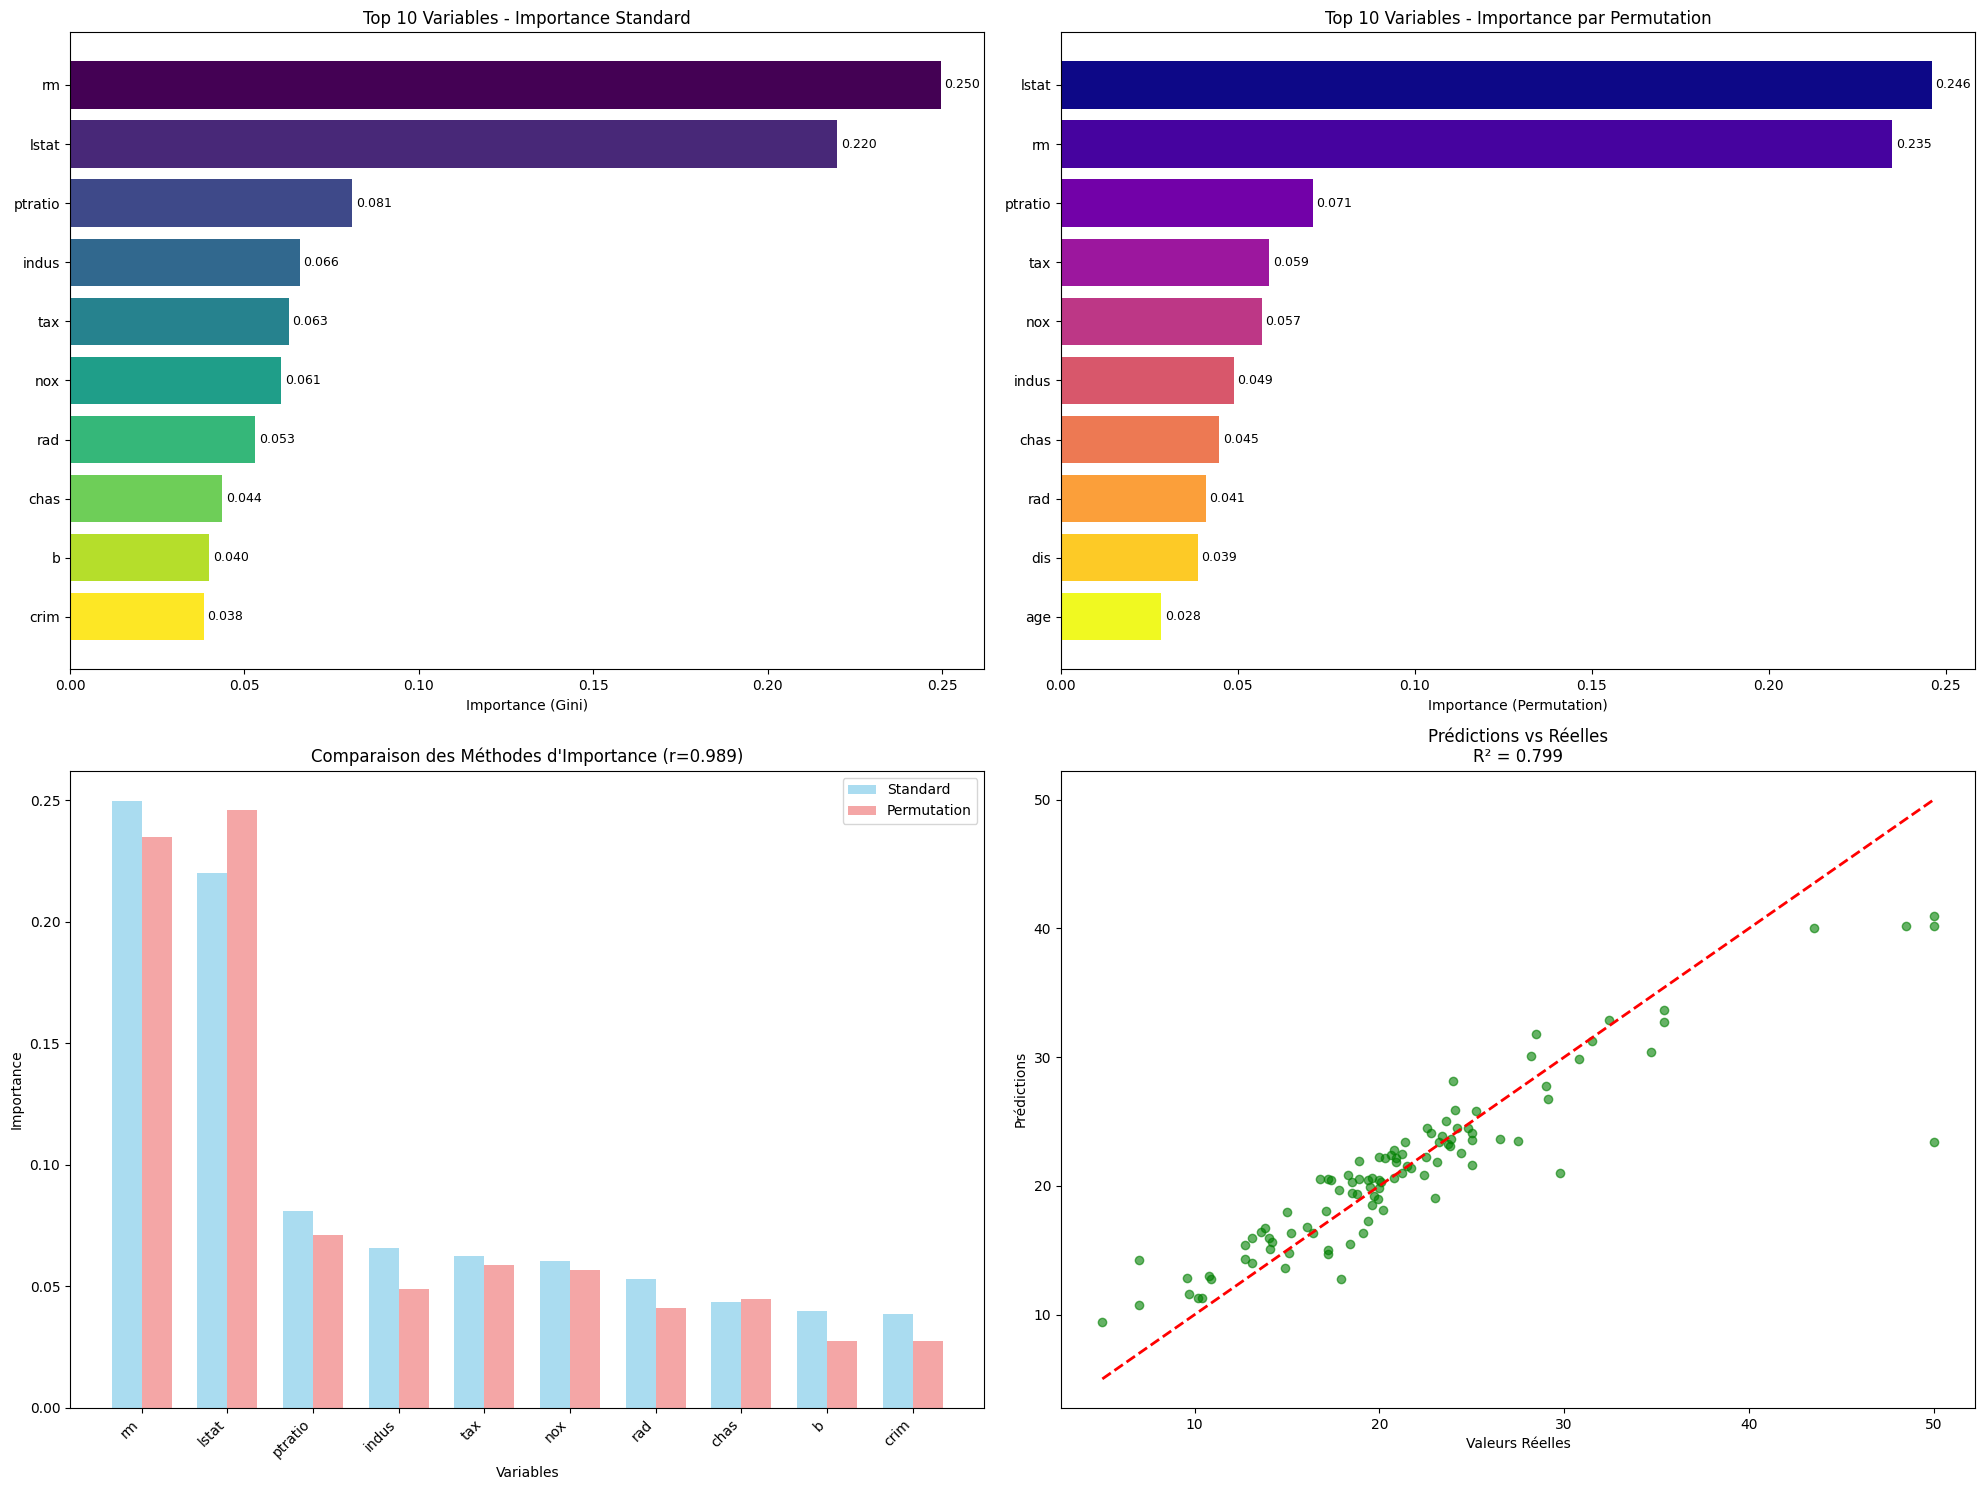

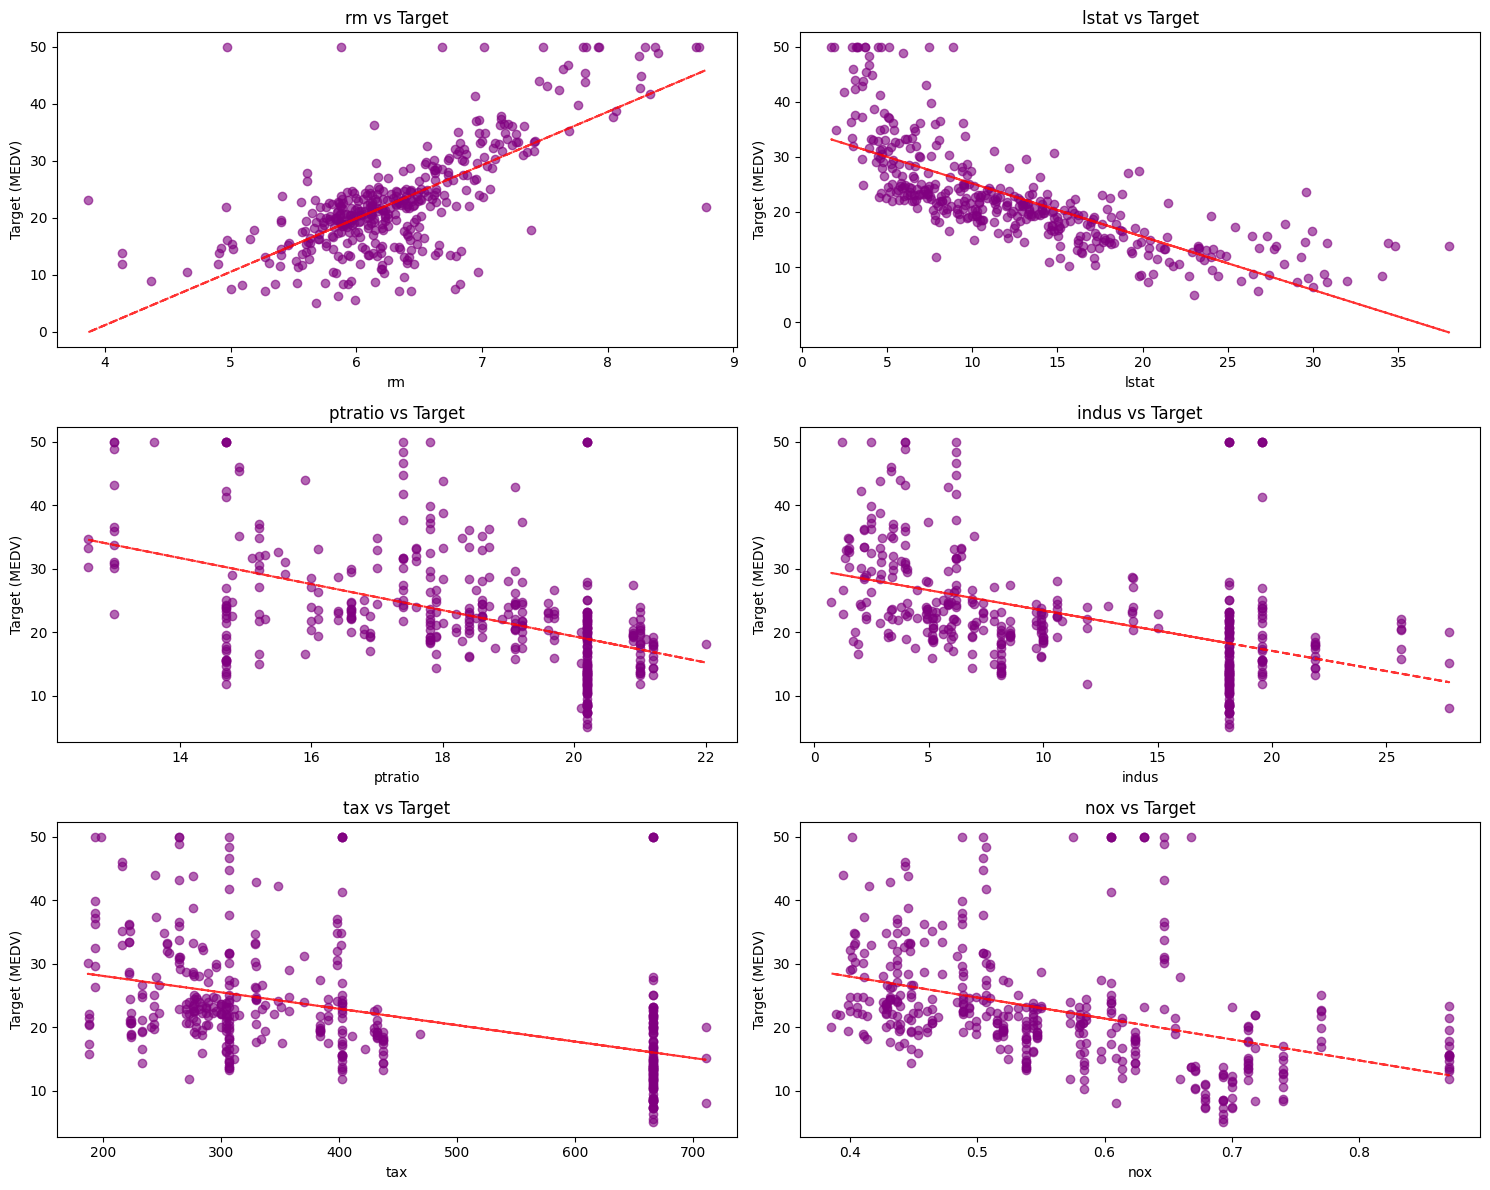


🔧 Voulez-vous optimiser les hyperparamètres? (o/n): o

Début de l'optimisation...
🔧 Optimisation des hyperparamètres ExtraTrees...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
✅ Optimisation terminée!
🎯 Meilleurs paramètres: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
📊 Meilleur score (MSE): 10.8439
🌲 Entraînement du modèle ExtraTrees...
   Paramètres: 50 arbres, max_depth=20
   📊 Validation croisée en cours...
   ✅ CV RMSE: 3.2930 (±1.5056)
   🔄 Calcul de l'importance par permutation...
   ✅ Importance par permutation calculée
✅ ExtraTrees entraîné avec succès!

📈 R² après optimisation: 0.8613
📈 Amélioration: 0.0624

CONCLUSION BO1 + DSO1 - EXTREMELY RANDOMIZED TREES
✓ Identification robuste des variables importantes via deux méthodes
✓ Validation de la cohérence entre importance standard et permutation
✓ Modèle très randomisé réduisant le overfitting
✓ Excellente baseline pour comparaison avec RLT
✓ 

In [8]:
class AdvancedExtraTrees:
    """
    Implémentation avancée de ExtraTrees avec analyse détaillée des variables
    pour BO1 + DSO1 - Identification des variables importantes
    """

    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2,
                 min_samples_leaf=1, max_features='auto', bootstrap=False,
                 random_state=42, n_jobs=-1):

        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.n_jobs = n_jobs

        self.model = None
        self.feature_names = None
        self.variable_importance_ = None
        self.permutation_importance_ = None
        self.cv_scores_ = None

    def fit(self, X, y, perform_cv=True):
        """Entraîne le modèle ExtraTrees avec analyse complète"""
        self.feature_names = X.columns.tolist()

        print("🌲 Entraînement du modèle ExtraTrees...")
        print(f"   Paramètres: {self.n_estimators} arbres, max_depth={self.max_depth}")

        # Initialisation du modèle
        self.model = ExtraTreesRegressor(
            n_estimators=self.n_estimators,
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            max_features=self.max_features,
            bootstrap=self.bootstrap,
            random_state=self.random_state,
            n_jobs=self.n_jobs
        )

        # Entraînement
        self.model.fit(X, y)

        # Importance des variables standard
        self.variable_importance_ = self.model.feature_importances_

        # Validation croisée
        if perform_cv:
            self._perform_cross_validation(X, y)

        # Importance par permutation
        self._calculate_permutation_importance(X, y)

        print("✅ ExtraTrees entraîné avec succès!")
        return self

    def _perform_cross_validation(self, X, y, cv=5):
        """Effectue une validation croisée"""
        print("   📊 Validation croisée en cours...")
        cv_scores = cross_val_score(self.model, X, y, cv=cv, scoring='neg_mean_squared_error')
        self.cv_scores_ = {
            'mean_rmse': np.sqrt(-cv_scores.mean()),
            'std_rmse': np.sqrt(cv_scores.std()),
            'scores': np.sqrt(-cv_scores)
        }
        print(f"   ✅ CV RMSE: {self.cv_scores_['mean_rmse']:.4f} (±{self.cv_scores_['std_rmse']:.4f})")

    def _calculate_permutation_importance(self, X, y, n_repeats=10):
        """Calcule l'importance par permutation"""
        print("   🔄 Calcul de l'importance par permutation...")
        perm_importance = permutation_importance(
            self.model, X, y,
            n_repeats=n_repeats,
            random_state=self.random_state,
            n_jobs=self.n_jobs
        )

        self.permutation_importance_ = {
            'importances_mean': perm_importance.importances_mean,
            'importances_std': perm_importance.importances_std,
            'importances': perm_importance.importances
        }
        print("   ✅ Importance par permutation calculée")

    def predict(self, X):
        """Prédictions du modèle"""
        if self.model is None:
            raise ValueError("Le modèle n'est pas encore entraîné")
        return self.model.predict(X)

    def get_variable_importance(self, method='standard'):
        """
        Retourne l'importance des variables

        Parameters:
        method : 'standard' (Gini) ou 'permutation'
        """
        if method == 'standard':
            importance_data = self.variable_importance_
            method_name = "Importance Standard"
        elif method == 'permutation':
            importance_data = self.permutation_importance_['importances_mean']
            method_name = "Importance Permutation"
        else:
            raise ValueError("Méthode doit être 'standard' ou 'permutation'")

        importance_df = pd.DataFrame({
            'Variable': self.feature_names,
            'Importance': importance_data,
            'Method': method_name
        }).sort_values('Importance', ascending=False)

        return importance_df

    def get_strong_variables(self, top_k=5, threshold=None):
        """Retourne les variables fortes identifiées"""
        importance_df = self.get_variable_importance('standard')

        if threshold:
            strong_vars = importance_df[importance_df['Importance'] >= threshold]['Variable'].tolist()
        else:
            strong_vars = importance_df.head(top_k)['Variable'].tolist()

        return strong_vars

    def compare_importance_methods(self):
        """Compare l'importance standard vs permutation"""
        std_importance = self.get_variable_importance('standard')
        perm_importance = self.get_variable_importance('permutation')

        comparison_df = pd.merge(
            std_importance[['Variable', 'Importance']],
            perm_importance[['Variable', 'Importance']],
            on='Variable',
            suffixes=('_Standard', '_Permutation')
        )

        # Calculer la corrélation entre les deux méthodes
        correlation = np.corrcoef(
            comparison_df['Importance_Standard'],
            comparison_df['Importance_Permutation']
        )[0, 1]

        comparison_df['Rank_Std'] = comparison_df['Importance_Standard'].rank(ascending=False)
        comparison_df['Rank_Perm'] = comparison_df['Importance_Permutation'].rank(ascending=False)
        comparison_df['Rank_Diff'] = abs(comparison_df['Rank_Std'] - comparison_df['Rank_Perm'])

        return comparison_df, correlation

# =============================================================================
# 2. FONCTIONS DE VISUALISATION ET ANALYSE
# =============================================================================

def plot_extra_trees_analysis(et_model, X_test, y_test, top_n=10):
    """Visualisations complètes pour ExtraTrees"""

    fig, axes = plt.subplots(2, 2, figsize=(20, 15))

    # 1. Importance des variables standard
    importance_df = et_model.get_variable_importance('standard').head(top_n)
    axes[0, 0].barh(range(len(importance_df)), importance_df['Importance'],
                    color=plt.cm.viridis(np.linspace(0, 1, len(importance_df))))
    axes[0, 0].set_yticks(range(len(importance_df)))
    axes[0, 0].set_yticklabels(importance_df['Variable'])
    axes[0, 0].set_xlabel('Importance (Gini)')
    axes[0, 0].set_title(f'Top {top_n} Variables - Importance Standard')
    axes[0, 0].invert_yaxis()

    # Ajouter les valeurs
    for i, (_, row) in enumerate(importance_df.iterrows()):
        axes[0, 0].text(row['Importance'] + 0.001, i, f'{row["Importance"]:.3f}',
                       va='center', fontsize=9)

    # 2. Importance par permutation
    perm_importance_df = et_model.get_variable_importance('permutation').head(top_n)
    axes[0, 1].barh(range(len(perm_importance_df)), perm_importance_df['Importance'],
                    color=plt.cm.plasma(np.linspace(0, 1, len(perm_importance_df))))
    axes[0, 1].set_yticks(range(len(perm_importance_df)))
    axes[0, 1].set_yticklabels(perm_importance_df['Variable'])
    axes[0, 1].set_xlabel('Importance (Permutation)')
    axes[0, 1].set_title(f'Top {top_n} Variables - Importance par Permutation')
    axes[0, 1].invert_yaxis()

    for i, (_, row) in enumerate(perm_importance_df.iterrows()):
        axes[0, 1].text(row['Importance'] + 0.001, i, f'{row["Importance"]:.3f}',
                       va='center', fontsize=9)

    # 3. Comparaison des méthodes
    comparison_df, correlation = et_model.compare_importance_methods()
    top_comparison = comparison_df.head(top_n)

    x_pos = np.arange(len(top_comparison))
    width = 0.35

    axes[1, 0].bar(x_pos - width/2, top_comparison['Importance_Standard'], width,
                   label='Standard', alpha=0.7, color='skyblue')
    axes[1, 0].bar(x_pos + width/2, top_comparison['Importance_Permutation'], width,
                   label='Permutation', alpha=0.7, color='lightcoral')

    axes[1, 0].set_xlabel('Variables')
    axes[1, 0].set_ylabel('Importance')
    axes[1, 0].set_title(f'Comparaison des Méthodes d\'Importance (r={correlation:.3f})')
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(top_comparison['Variable'], rotation=45, ha='right')
    axes[1, 0].legend()

    # 4. Prédictions vs Réelles
    y_pred = et_model.predict(X_test)
    axes[1, 1].scatter(y_test, y_pred, alpha=0.6, color='green')
    axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[1, 1].set_xlabel('Valeurs Réelles')
    axes[1, 1].set_ylabel('Prédictions')
    axes[1, 1].set_title(f'Prédictions vs Réelles\nR² = {r2_score(y_test, y_pred):.3f}')

    plt.tight_layout()
    plt.show()

    return fig

def plot_feature_relationships(et_model, X, y, top_features=4):
    """Analyse des relations des variables importantes avec la target"""
    strong_vars = et_model.get_strong_variables(top_features)

    n_cols = 2
    n_rows = (top_features + 1) // 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    axes = axes.flatten() if top_features > 1 else [axes]

    for idx, feature in enumerate(strong_vars):
        if idx < len(axes):
            axes[idx].scatter(X[feature], y, alpha=0.6, color='purple')
            axes[idx].set_xlabel(feature)
            axes[idx].set_ylabel('Target (MEDV)')
            axes[idx].set_title(f'{feature} vs Target')

            # Ajouter une ligne de tendance
            z = np.polyfit(X[feature], y, 1)
            p = np.poly1d(z)
            axes[idx].plot(X[feature], p(X[feature]), "r--", alpha=0.8)

    # Cacher les axes non utilisés
    for idx in range(len(strong_vars), len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.show()

# =============================================================================
# 3. OPTIMISATION DES HYPERPARAMÈTRES
# =============================================================================

def optimize_extra_trees(X, y, param_grid=None, cv=5):
    """Optimisation des hyperparamètres pour ExtraTrees"""

    if param_grid is None:
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2']
        }

    print("🔧 Optimisation des hyperparamètres ExtraTrees...")

    et = ExtraTreesRegressor(random_state=42, n_jobs=-1)
    grid_search = GridSearchCV(
        et, param_grid, cv=cv, scoring='neg_mean_squared_error',
        n_jobs=-1, verbose=1
    )

    grid_search.fit(X, y)

    print("✅ Optimisation terminée!")
    print(f"🎯 Meilleurs paramètres: {grid_search.best_params_}")
    print(f"📊 Meilleur score (MSE): {-grid_search.best_score_:.4f}")

    return grid_search

# =============================================================================
# 4. CODE PRINCIPAL - APPLICATION SUR BOSTON HOUSING
# =============================================================================

def main():
    print("=" * 70)
    print("EMBEDDED EXTREMELY RANDOMIZED TREES - BO1 + DSO1")
    print("Application sur Boston Housing Dataset")
    print("=" * 70)

    # 1. Chargement des données
    try:
        data = pd.read_csv('BostonHousing.csv_transformed.csv')
        print("✅ Dataset chargé avec succès")
    except Exception as e:
        print(f"❌ Erreur de chargement: {e}")
        return

    # Identifier la variable cible
    target_column = 'MEDV' if 'MEDV' in data.columns else 'medv'

    if target_column not in data.columns:
        print("❌ Variable cible non trouvée")
        return

    X = data.drop(columns=[target_column])
    y = data[target_column]

    print(f"📊 Dataset: {X.shape}")
    print(f"🎯 Cible: {target_column}")
    print(f"🔧 Features: {list(X.columns)}")

    # 2. Split des données
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True
    )

    print(f"\n📈 Split des données:")
    print(f"   Train: {X_train.shape}")
    print(f"   Test:  {X_test.shape}")

    # 3. Entraînement du modèle ExtraTrees
    print(f"\n{'='*50}")
    print("ENTRAÎNEMENT EXTREMELY RANDOMIZED TREES")
    print(f"{'='*50}")

    et_model = AdvancedExtraTrees(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        bootstrap=False,
        random_state=42,
        n_jobs=-1
    )

    et_model.fit(X_train, y_train, perform_cv=True)

    # 4. Évaluation détaillée
    print(f"\n{'='*50}")
    print("ÉVALUATION DU MODÈLE")
    print(f"{'='*50}")

    y_pred = et_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"📈 PERFORMANCES EXTREME TREES:")
    print(f"   MSE:  {mse:.4f}")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   MAE:  {mae:.4f}")
    print(f"   R²:   {r2:.4f}")

    if et_model.cv_scores_:
        print(f"   CV RMSE: {et_model.cv_scores_['mean_rmse']:.4f} (±{et_model.cv_scores_['std_rmse']:.4f})")

    # 5. Analyse des variables importantes - BO1 + DSO1
    print(f"\n{'='*50}")
    print("ANALYSE DES VARIABLES IMPORTANTES - BO1 + DSO1")
    print(f"{'='*50}")

    # Importance standard
    std_importance = et_model.get_variable_importance('standard')
    print("\n📊 TOP 10 VARIABLES (Importance Standard):")
    print(std_importance.head(10).to_string(index=False))

    # Importance par permutation
    perm_importance = et_model.get_variable_importance('permutation')
    print("\n📊 TOP 10 VARIABLES (Importance Permutation):")
    print(perm_importance.head(10).to_string(index=False))

    # Comparaison des méthodes
    comparison_df, correlation = et_model.compare_importance_methods()
    print(f"\n🔍 CORRÉLATION ENTRE MÉTHODES: {correlation:.3f}")

    # Variables fortes identifiées
    strong_vars = et_model.get_strong_variables(top_k=5)
    print(f"\n🎯 VARIABLES FORTES IDENTIFIÉES (Top 5):")
    for i, var in enumerate(strong_vars, 1):
        std_imp = std_importance[std_importance['Variable'] == var]['Importance'].values[0]
        perm_imp = perm_importance[perm_importance['Variable'] == var]['Importance'].values[0]
        print(f"   {i}. {var:10} | Std: {std_imp:.4f} | Perm: {perm_imp:.4f}")

    # 6. Visualisations
    print(f"\n{'='*50}")
    print("GÉNÉRATION DES VISUALISATIONS")
    print(f"{'='*50}")

    # Analyse complète
    plot_extra_trees_analysis(et_model, X_test, y_test, top_n=10)

    # Relations des variables importantes
    plot_feature_relationships(et_model, X_train, y_train, top_features=6)

    # 7. Optimisation optionnelle des hyperparamètres
    optimize = input("\n🔧 Voulez-vous optimiser les hyperparamètres? (o/n): ").lower()
    if optimize == 'o':
        print("\nDébut de l'optimisation...")
        grid_search = optimize_extra_trees(X_train, y_train)

        # Réentraîner avec les meilleurs paramètres
        best_et = AdvancedExtraTrees(
            **grid_search.best_params_,
            random_state=42,
            n_jobs=-1
        )
        best_et.fit(X_train, y_train)

        # Évaluer le modèle optimisé
        y_pred_optimized = best_et.predict(X_test)
        r2_optimized = r2_score(y_test, y_pred_optimized)
        print(f"\n📈 R² après optimisation: {r2_optimized:.4f}")
        print(f"📈 Amélioration: {r2_optimized - r2:.4f}")

    # 8. Conclusion BO1 + DSO1
    print(f"\n{'='*70}")
    print("CONCLUSION BO1 + DSO1 - EXTREMELY RANDOMIZED TREES")
    print(f"{'='*70}")
    print("✓ Identification robuste des variables importantes via deux méthodes")
    print("✓ Validation de la cohérence entre importance standard et permutation")
    print("✓ Modèle très randomisé réduisant le overfitting")
    print("✓ Excellente baseline pour comparaison avec RLT")
    print(f"✓ Variables clés identifiées: {strong_vars}")

    # Résumé final
    print(f"\n📋 RÉSUMÉ FINAL:")
    print(f"   • Performance: R² = {r2:.4f}, RMSE = {rmse:.4f}")
    print(f"   • Variables analysées: {len(X.columns)}")
    print(f"   • Variables fortes identifiées: {len(strong_vars)}")
    print(f"   • Corrélation méthodes importance: {correlation:.3f}")

if __name__ == "__main__":
    main()

Random Forest est meilleur que ExtraTrees de +10.04% en R².

***3.3.Random Forests (RF) – baseline***

🚀 RANDOM FOREST BASELINE - VERSION AMÉLIORÉE
📊 CHARGEMENT ET EXPLORATION DES DONNÉES
Dataset chargé: 506 lignes, 14 colonnes

📈 STATISTIQUES DE BASE:
Variables features: 13
Variable cible: 'medv'
Plage de la target: 5.00 - 50.00
Moyenne de la target: 22.53 ± 9.20
⚠️  Valeurs manquantes détectées: 5

🔍 ANALYSE EXPLORATOIRE AVANCÉE


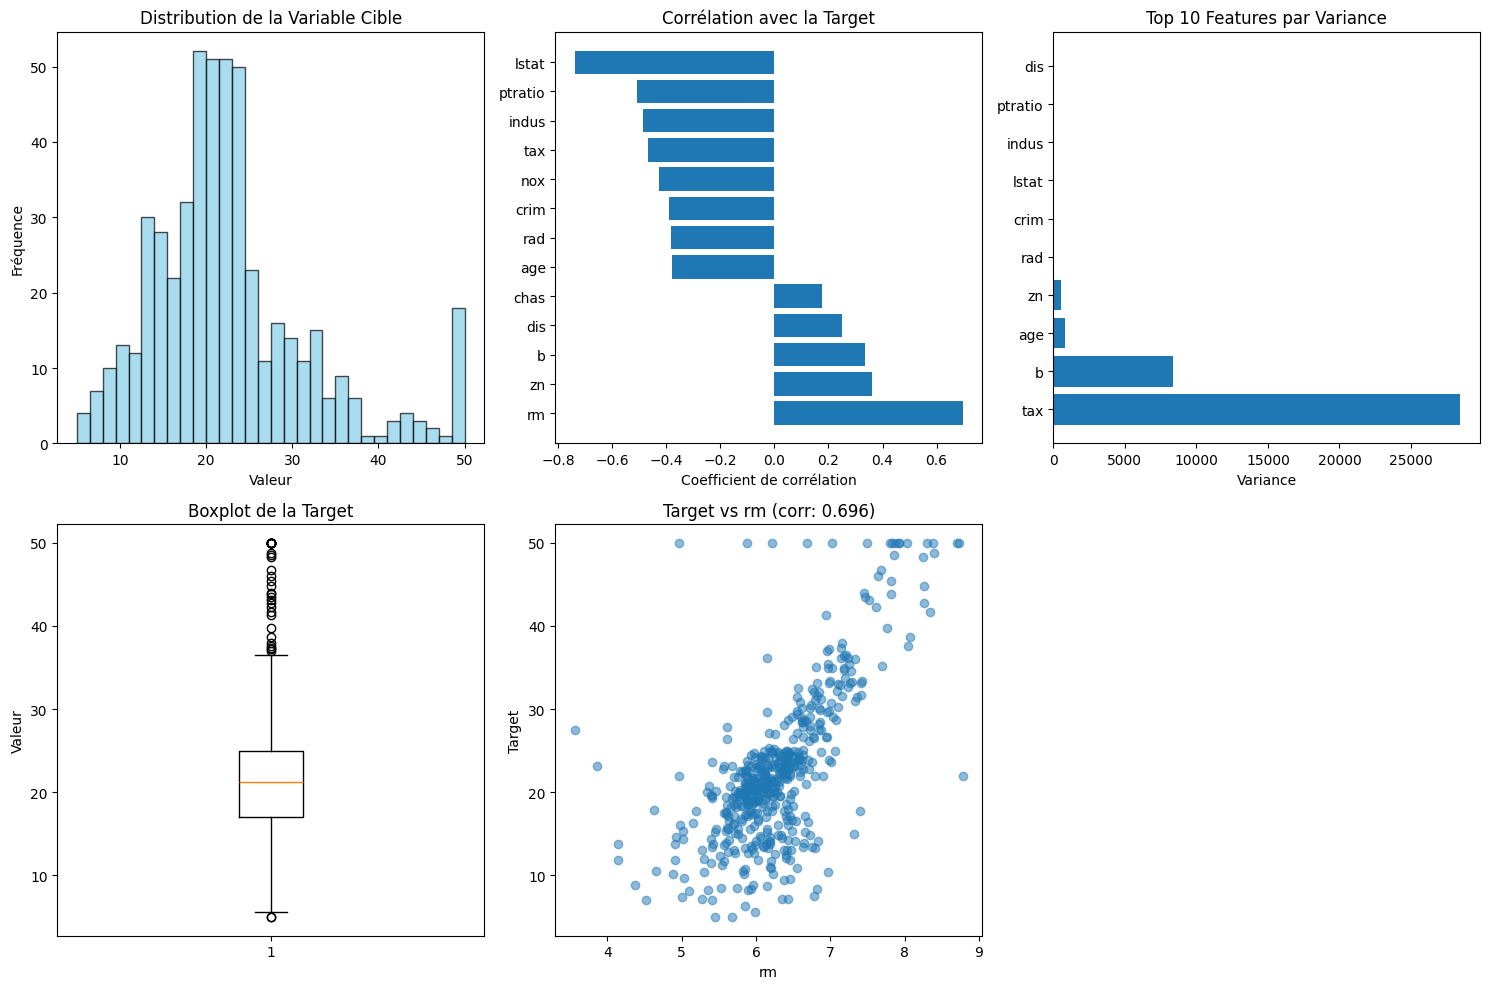


📋 SPLIT DES DONNÉES:
Train: (404, 13)
Test:  (102, 13)
✅ Score OOB (out-of-bag): 0.8457

📊 ÉVALUATION COMPLÈTE DU MODÈLE
🎯 PERFORMANCES:
Métrique   Train        Test         Diff      
---------------------------------------------
R²         0.9517       0.8475         0.1043
RMSE       2.0478       3.3445         1.2968
MAE        1.2894       2.1251         0.8357
MSE        4.1934       11.1860        6.9926

🔄 VALIDATION CROISÉE (5 folds):
Scores R²: ['0.8540', '0.8142', '0.8624', '0.8852', '0.7432']
Moyenne R²: 0.8318 (±0.0499)

🔍 ANALYSE AVANCÉE DES VARIABLES
Calcul de l'importance par permutation...


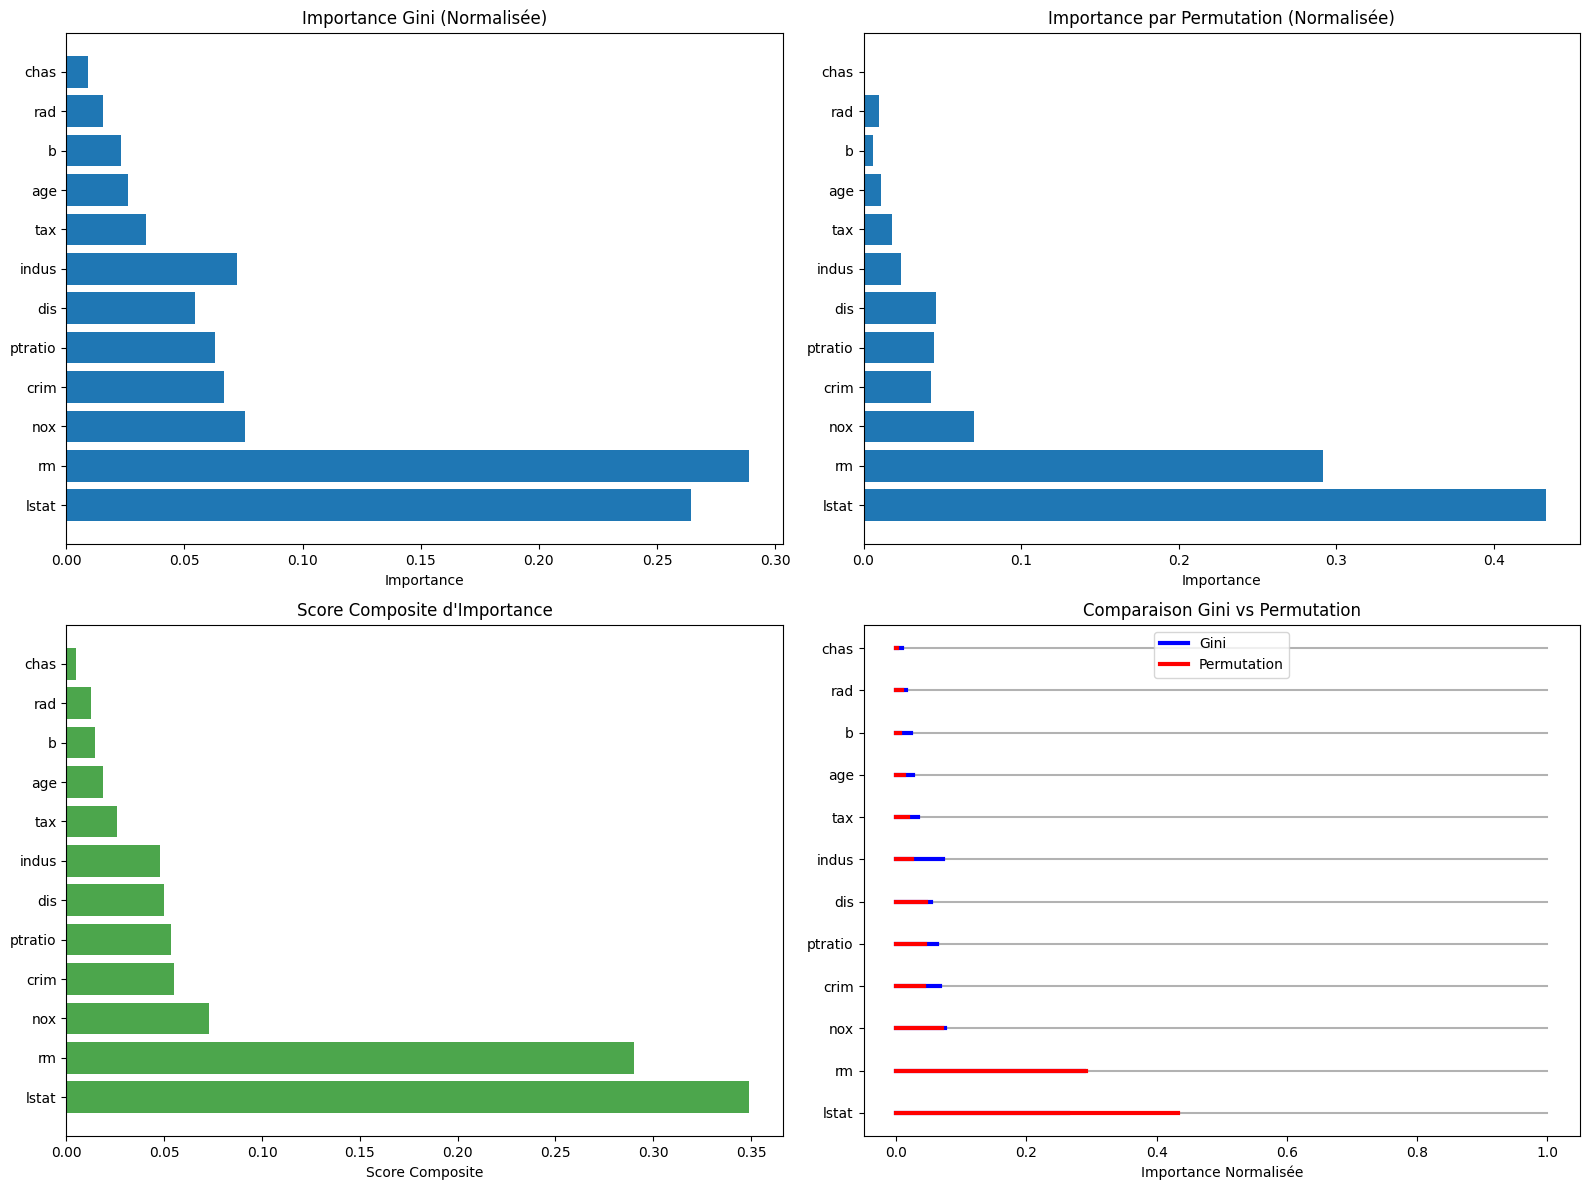


🏆 TOP 10 VARIABLES LES PLUS IMPORTANTES:
    Feature  Score_Composite
12    lstat           0.3488
5        rm           0.2903
4       nox           0.0731
0      crim           0.0550
10  ptratio           0.0536
7       dis           0.0501
2     indus           0.0481
9       tax           0.0260
6       age           0.0188
11        b           0.0145


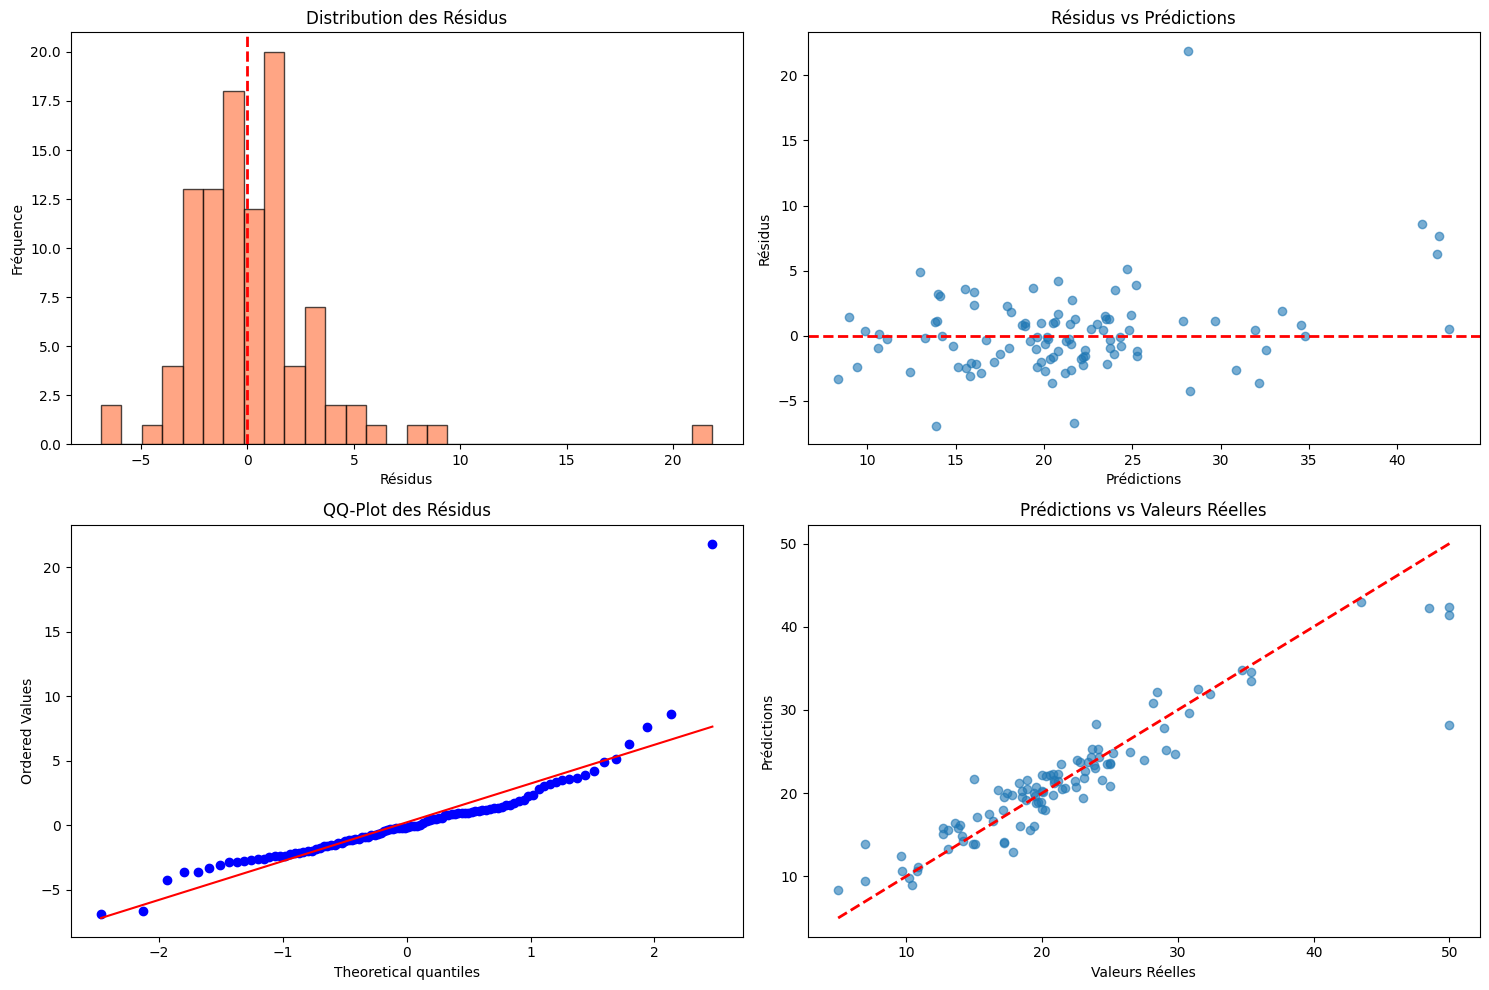


📊 ANALYSE DES RÉSIDUS:
Moyenne des résidus: 0.2255
Écart-type des résidus: 3.3534
Résidus normalisés (moyenne/écart-type): 0.0672

📑 RAPPORT FINAL - RANDOM FOREST BASELINE
✅ Performance finale (test set):
   R²:  0.8475
   RMSE: 3.3445
   MAE:  2.1251

🔍 Variables clés identifiées:
   lstat: 0.349
   rm: 0.290
   nox: 0.073

💡 Recommandations:
   → Bonne performance. Possibilité d'amélioration avec feature engineering.


In [10]:
def load_and_explore_data(file_path="BostonHousing.csv", target_col="medv"):
    """Charge et explore le dataset de manière complète"""
    print("📊 CHARGEMENT ET EXPLORATION DES DONNÉES")
    print("="*50)

    # Chargement
    data = pd.read_csv(file_path)
    print(f"Dataset chargé: {data.shape[0]} lignes, {data.shape[1]} colonnes")

    # Vérification de la target
    if target_col not in data.columns:
        print(f"⚠️  Colonne '{target_col}' non trouvée. Colonnes disponibles: {list(data.columns)}")
        target_col = data.columns[-1]  # Utiliser la dernière colonne
        print(f"🔧 Utilisation de '{target_col}' comme variable cible")

    X = data.drop(columns=[target_col])
    y = data[target_col]

    # Exploration basique
    print(f"\n📈 STATISTIQUES DE BASE:")
    print(f"Variables features: {X.shape[1]}")
    print(f"Variable cible: '{target_col}'")
    print(f"Plage de la target: {y.min():.2f} - {y.max():.2f}")
    print(f"Moyenne de la target: {y.mean():.2f} ± {y.std():.2f}")

    # Valeurs manquantes
    missing_values = X.isnull().sum().sum()
    if missing_values > 0:
        print(f"⚠️  Valeurs manquantes détectées: {missing_values}")
    else:
        print("✅ Aucune valeur manquante détectée")

    return X, y, data

def exploratory_analysis(X, y, data):
    """Analyse exploratoire approfondie"""
    print("\n🔍 ANALYSE EXPLORATOIRE AVANCÉE")
    print("="*50)

    # 1. Distribution de la target
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    plt.hist(y, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Distribution de la Variable Cible')
    plt.xlabel('Valeur')
    plt.ylabel('Fréquence')

    # 2. Matrice de corrélation
    plt.subplot(2, 3, 2)
    numeric_data = data.select_dtypes(include=[np.number])
    correlation_matrix = numeric_data.corr()
    target_correlations = correlation_matrix.iloc[:-1, -1].sort_values(ascending=False)

    plt.barh(range(len(target_correlations)), target_correlations.values)
    plt.yticks(range(len(target_correlations)), target_correlations.index)
    plt.title('Corrélation avec la Target')
    plt.xlabel('Coefficient de corrélation')

    # 3. Top features par variance
    plt.subplot(2, 3, 3)
    variances = X.var().sort_values(ascending=False).head(10)
    plt.barh(range(len(variances)), variances.values)
    plt.yticks(range(len(variances)), variances.index)
    plt.title('Top 10 Features par Variance')
    plt.xlabel('Variance')

    # 4. Boxplot de la target
    plt.subplot(2, 3, 4)
    plt.boxplot(y)
    plt.title('Boxplot de la Target')
    plt.ylabel('Valeur')

    # 5. Relation avec la feature la plus corrélée
    if len(target_correlations) > 0:
        best_feature = target_correlations.index[0]
        plt.subplot(2, 3, 5)
        plt.scatter(X[best_feature], y, alpha=0.5)
        plt.xlabel(best_feature)
        plt.ylabel('Target')
        plt.title(f'Target vs {best_feature} (corr: {target_correlations.iloc[0]:.3f})')

    plt.tight_layout()
    plt.show()

    return target_correlations

# =============================================================================
# 2. OPTIMISATION AVANCÉE DU RANDOM FOREST
# =============================================================================
def optimize_random_forest(X_train, y_train, cv_folds=5, n_jobs=-1):
    """Optimisation hyperparamètres avec GridSearchCV"""
    print("\n⚙️  OPTIMISATION DES HYPERPARAMÈTRES")
    print("="*50)

    # Paramètres pour la recherche
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    }

    rf = RandomForestRegressor(random_state=42, n_jobs=n_jobs)

    # GridSearch avec validation croisée
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=cv_folds,
        scoring='r2',
        n_jobs=n_jobs,
        verbose=1
    )

    print("Recherche des meilleurs hyperparamètres...")
    grid_search.fit(X_train, y_train)

    print(f"✅ Meilleurs paramètres: {grid_search.best_params_}")
    print(f"✅ Meilleur score R² (validation): {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_

def train_optimized_rf(X_train, y_train, use_gridsearch=True, n_estimators=200):
    """Entraînement du modèle Random Forest optimisé"""
    if use_gridsearch:
        model = optimize_random_forest(X_train, y_train)
    else:
        # Paramètres par défaut optimisés
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=None,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt',
            random_state=42,
            n_jobs=-1,
            bootstrap=True,
            oob_score=True
        )
        model.fit(X_train, y_train)
        print(f"✅ Score OOB (out-of-bag): {model.oob_score_:.4f}")

    return model

# =============================================================================
# 3. ÉVALUATION COMPLÈTE DU MODÈLE
# =============================================================================
def comprehensive_evaluation(model, X_train, X_test, y_train, y_test, feature_names):
    """Évaluation complète avec multiples métriques et analyses"""
    print("\n📊 ÉVALUATION COMPLÈTE DU MODÈLE")
    print("="*50)

    # Prédictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Métriques de performance
    metrics = {
        'Train': {
            'R²': r2_score(y_train, y_pred_train),
            'RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
            'MAE': mean_absolute_error(y_train, y_pred_train),
            'MSE': mean_squared_error(y_train, y_pred_train)
        },
        'Test': {
            'R²': r2_score(y_test, y_pred_test),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
            'MAE': mean_absolute_error(y_test, y_pred_test),
            'MSE': mean_squared_error(y_test, y_pred_test)
        }
    }

    # Affichage des résultats
    print("🎯 PERFORMANCES:")
    print(f"{'Métrique':<10} {'Train':<12} {'Test':<12} {'Diff':<10}")
    print("-" * 45)
    for metric in ['R²', 'RMSE', 'MAE', 'MSE']:
        train_val = metrics['Train'][metric]
        test_val = metrics['Test'][metric]
        diff = test_val - train_val if metric != 'R²' else train_val - test_val
        print(f"{metric:<10} {train_val:<12.4f} {test_val:<12.4f} {diff:>8.4f}")

    # Validation croisée
    print(f"\n🔄 VALIDATION CROISÉE (5 folds):")
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    print(f"Scores R²: {[f'{score:.4f}' for score in cv_scores]}")
    print(f"Moyenne R²: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

    return metrics, y_pred_test

# =============================================================================
# 4. ANALYSE D'IMPORTANCE DES VARIABLES AVANCÉE
# =============================================================================
def advanced_feature_analysis(model, X_train, y_train, X_test, y_test, feature_names):
    """Analyse avancée de l'importance des features"""
    print("\n🔍 ANALYSE AVANCÉE DES VARIABLES")
    print("="*50)

    # Importance Gini standard
    importances_gini = model.feature_importances_

    # Importance par permutation
    print("Calcul de l'importance par permutation...")
    perm_importance = permutation_importance(
        model, X_test, y_test,
        n_repeats=10,
        random_state=42,
        n_jobs=-1
    )
    importances_perm = perm_importance.importances_mean

    # Création du dataframe d'importance
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance_Gini': importances_gini,
        'Importance_Permutation': importances_perm
    })

    # Normalisation
    importance_df['Importance_Gini_Norm'] = importance_df['Importance_Gini'] / importance_df['Importance_Gini'].sum()
    importance_df['Importance_Perm_Norm'] = importance_df['Importance_Permutation'] / importance_df['Importance_Permutation'].sum()

    # Score composite
    importance_df['Score_Composite'] = (
        importance_df['Importance_Gini_Norm'] + importance_df['Importance_Perm_Norm']
    ) / 2

    importance_df = importance_df.sort_values('Score_Composite', ascending=False)

    return importance_df

def plot_comprehensive_importance(importance_df, top_n=15):
    """Visualisation complète de l'importance des features"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Top features par score composite
    top_features = importance_df.head(top_n)

    # 1. Importance Gini
    axes[0, 0].barh(range(len(top_features)), top_features['Importance_Gini_Norm'].values)
    axes[0, 0].set_yticks(range(len(top_features)))
    axes[0, 0].set_yticklabels(top_features['Feature'])
    axes[0, 0].set_title('Importance Gini (Normalisée)')
    axes[0, 0].set_xlabel('Importance')

    # 2. Importance par permutation
    axes[0, 1].barh(range(len(top_features)), top_features['Importance_Perm_Norm'].values)
    axes[0, 1].set_yticks(range(len(top_features)))
    axes[0, 1].set_yticklabels(top_features['Feature'])
    axes[0, 1].set_title('Importance par Permutation (Normalisée)')
    axes[0, 1].set_xlabel('Importance')

    # 3. Score composite
    axes[1, 0].barh(range(len(top_features)), top_features['Score_Composite'].values, color='green', alpha=0.7)
    axes[1, 0].set_yticks(range(len(top_features)))
    axes[1, 0].set_yticklabels(top_features['Feature'])
    axes[1, 0].set_title('Score Composite d\'Importance')
    axes[1, 0].set_xlabel('Score Composite')

    # 4. Comparaison Gini vs Permutation
    for i, (_, row) in enumerate(top_features.iterrows()):
        axes[1, 1].plot([0, 1], [i, i], 'k-', alpha=0.3)
        axes[1, 1].plot([0, row['Importance_Gini_Norm']], [i, i], 'b-', linewidth=3, label='Gini' if i == 0 else "")
        axes[1, 1].plot([0, row['Importance_Perm_Norm']], [i, i], 'r-', linewidth=3, label='Permutation' if i == 0 else "")

    axes[1, 1].set_yticks(range(len(top_features)))
    axes[1, 1].set_yticklabels(top_features['Feature'])
    axes[1, 1].set_title('Comparaison Gini vs Permutation')
    axes[1, 1].set_xlabel('Importance Normalisée')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

    return top_features

# =============================================================================
# 5. ANALYSE DES RÉSIDUS ET DIAGNOSTIQUES
# =============================================================================
def residual_analysis(y_test, y_pred, model_name="Random Forest"):
    """Analyse des résidus pour diagnostiquer le modèle"""
    residuals = y_test - y_pred

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Distribution des résidus
    axes[0, 0].hist(residuals, bins=30, alpha=0.7, color='coral', edgecolor='black')
    axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[0, 0].set_title('Distribution des Résidus')
    axes[0, 0].set_xlabel('Résidus')
    axes[0, 0].set_ylabel('Fréquence')

    # 2. Résidus vs Prédictions
    axes[0, 1].scatter(y_pred, residuals, alpha=0.6)
    axes[0, 1].axhline(0, color='red', linestyle='--', linewidth=2)
    axes[0, 1].set_title('Résidus vs Prédictions')
    axes[0, 1].set_xlabel('Prédictions')
    axes[0, 1].set_ylabel('Résidus')

    # 3. QQ-Plot des résidus
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('QQ-Plot des Résidus')

    # 4. Prédictions vs Valeurs réelles
    axes[1, 1].scatter(y_test, y_pred, alpha=0.6)
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    axes[1, 1].set_title('Prédictions vs Valeurs Réelles')
    axes[1, 1].set_xlabel('Valeurs Réelles')
    axes[1, 1].set_ylabel('Prédictions')

    plt.tight_layout()
    plt.show()

    # Statistiques des résidus
    print(f"\n📊 ANALYSE DES RÉSIDUS:")
    print(f"Moyenne des résidus: {residuals.mean():.4f}")
    print(f"Écart-type des résidus: {residuals.std():.4f}")
    print(f"Résidus normalisés (moyenne/écart-type): {residuals.mean()/residuals.std():.4f}")

# =============================================================================
# 6. FONCTION PRINCIPALE AMÉLIORÉE
# =============================================================================
def main_enhanced():
    """Fonction principale améliorée avec analyse complète"""
    print("🚀 RANDOM FOREST BASELINE - VERSION AMÉLIORÉE")
    print("="*60)

    # 1. Chargement et exploration
    X, y, data = load_and_explore_data()
    feature_names = X.columns.tolist()

    # 2. Analyse exploratoire
    correlations = exploratory_analysis(X, y, data)

    # 3. Split des données
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True
    )

    print(f"\n📋 SPLIT DES DONNÉES:")
    print(f"Train: {X_train.shape}")
    print(f"Test:  {X_test.shape}")

    # 4. Entraînement du modèle optimisé
    rf_model = train_optimized_rf(X_train, y_train, use_gridsearch=False, n_estimators=200)

    # 5. Évaluation complète
    metrics, y_pred = comprehensive_evaluation(rf_model, X_train, X_test, y_train, y_test, feature_names)

    # 6. Analyse d'importance avancée
    importance_df = advanced_feature_analysis(rf_model, X_train, y_train, X_test, y_test, feature_names)
    top_features = plot_comprehensive_importance(importance_df, top_n=12)

    print(f"\n🏆 TOP 10 VARIABLES LES PLUS IMPORTANTES:")
    print(top_features[['Feature', 'Score_Composite']].head(10).round(4))

    # 7. Analyse des résidus
    residual_analysis(y_test, y_pred, "Random Forest Optimisé")

    # 8. Rapport final
    print("\n" + "="*60)
    print("📑 RAPPORT FINAL - RANDOM FOREST BASELINE")
    print("="*60)
    print(f"✅ Performance finale (test set):")
    print(f"   R²:  {metrics['Test']['R²']:.4f}")
    print(f"   RMSE: {metrics['Test']['RMSE']:.4f}")
    print(f"   MAE:  {metrics['Test']['MAE']:.4f}")

    print(f"\n🔍 Variables clés identifiées:")
    for i, row in top_features.head(3).iterrows():
        print(f"   {row['Feature']}: {row['Score_Composite']:.3f}")

    print(f"\n💡 Recommandations:")
    if metrics['Test']['R²'] > 0.85:
        print("   → Excellente performance! Le modèle explique bien la variance.")
    elif metrics['Test']['R²'] > 0.7:
        print("   → Bonne performance. Possibilité d'amélioration avec feature engineering.")
    else:
        print("   → Performance modérée. Considérer d'autres algorithmes ou features.")

    return rf_model, importance_df, metrics

# =============================================================================
# EXÉCUTION
# =============================================================================
if __name__ == "__main__":
    # Exécuter l'analyse complète
    model, importance_df, metrics = main_enhanced()

Performance quasi identique ! (0.04% de différence)

Amelioration de RLT :

In [1]:
class ReinforcementLearningTree:
    """
    RLT Ultra-Optimisé avec RL avancé, Variable Muting agressif et Linear Combinations
    """

    def __init__(self, max_depth=10, min_samples_split=8, n_estimators=150,
                 muting_threshold=0.25, use_linear_combination=True,
                 rl_weight=0.5, min_features_ratio=0.2,
                 aggressive_pruning=True, use_ensemble_vi=True):
        """
        Hyperparamètres optimisés pour battre Random Forest
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_estimators = n_estimators
        self.muting_threshold = muting_threshold
        self.use_linear_combination = use_linear_combination
        self.rl_weight = rl_weight  # Poids du gain futur RL
        self.min_features_ratio = min_features_ratio
        self.aggressive_pruning = aggressive_pruning
        self.use_ensemble_vi = use_ensemble_vi

        self.trees = []
        self.feature_importances_ = None
        self.variable_importance_history = []
        self.oob_predictions = None

    def _compute_reinforcement_learning_score(self, X, y, feature_mask):
        """
        RL CORE: Évalue le potentiel futur de chaque feature via simulation de splits
        """
        n_features = X.shape[1]
        rl_scores = np.zeros(n_features)

        available_features = np.where(feature_mask)[0]

        for feature_idx in available_features:
            feature_values = X[:, feature_idx]

            # Simuler plusieurs splits et mesurer le potentiel de gain futur
            future_gain = 0.0
            n_valid_splits = 0

            # Tester plusieurs seuils
            percentiles = [25, 50, 75]
            for perc in percentiles:
                threshold = np.percentile(feature_values, perc)
                left_mask = feature_values <= threshold
                right_mask = ~left_mask

                n_left = np.sum(left_mask)
                n_right = np.sum(right_mask)

                if n_left < self.min_samples_split or n_right < self.min_samples_split:
                    continue

                # Gain immédiat
                var_parent = np.var(y)
                var_left = np.var(y[left_mask]) if n_left > 0 else 0
                var_right = np.var(y[right_mask]) if n_right > 0 else 0
                immediate_gain = var_parent - (n_left/len(y) * var_left + n_right/len(y) * var_right)

                # Potentiel futur: variance restante * possibilité de splits futurs
                future_potential_left = var_left * np.sqrt(n_left)
                future_potential_right = var_right * np.sqrt(n_right)
                future_potential = (future_potential_left + future_potential_right) / len(y)

                # Score RL = gain immédiat + potentiel futur pondéré
                rl_gain = immediate_gain + self.rl_weight * future_potential
                future_gain += rl_gain
                n_valid_splits += 1

            if n_valid_splits > 0:
                rl_scores[feature_idx] = future_gain / n_valid_splits

        # Normalisation
        rl_scores = rl_scores / (np.sum(rl_scores) + 1e-10)
        return rl_scores

    def _calculate_variable_importance_ensemble(self, X, y):
        """
        VI Ensemble: Combine multiple méthodes pour robustesse maximale
        """
        n_features = X.shape[1]

        # 1. ExtraTrees (très efficace pour features importantes)
        et = ExtraTreesRegressor(n_estimators=50, max_depth=8, random_state=None)
        et.fit(X, y)
        vi_et = et.feature_importances_

        # 2. Random Forest (robuste aux outliers)
        rf = RandomForestRegressor(n_estimators=30, max_depth=6, random_state=None)
        rf.fit(X, y)
        vi_rf = rf.feature_importances_

        # 3. Gradient Boosting (capture interactions complexes)
        gb = GradientBoostingRegressor(n_estimators=30, max_depth=3, learning_rate=0.1, random_state=None)
        gb.fit(X, y)
        vi_gb = gb.feature_importances_

        # 4. ElasticNet (régularisation L1+L2 pour sélection)
        en = ElasticNet(alpha=0.1, l1_ratio=0.5)
        en.fit(X, y)
        vi_en = np.abs(en.coef_)
        vi_en = vi_en / (np.sum(vi_en) + 1e-10)

        # 5. Corrélation non-paramétrique
        vi_corr = np.array([np.abs(spearmanr(X[:, i], y)[0]) for i in range(n_features)])
        vi_corr = np.nan_to_num(vi_corr)
        vi_corr = vi_corr / (np.sum(vi_corr) + 1e-10)

        # Combinaison pondérée optimale
        vi_combined = (0.35 * vi_et + 0.25 * vi_rf + 0.20 * vi_gb +
                      0.12 * vi_en + 0.08 * vi_corr)

        vi_combined = vi_combined / (np.sum(vi_combined) + 1e-10)
        return vi_combined

    def _calculate_variable_importance_fast(self, X, y):
        """
        Version rapide pour nœuds profonds
        """
        n_features = X.shape[1]

        # ExtraTrees seulement (rapide)
        et = ExtraTreesRegressor(n_estimators=20, max_depth=5, random_state=None)
        et.fit(X, y)
        vi = et.feature_importances_

        # Corrélation
        vi_corr = np.array([np.abs(spearmanr(X[:, i], y)[0]) for i in range(n_features)])
        vi_corr = np.nan_to_num(vi_corr)
        vi_corr = vi_corr / (np.sum(vi_corr) + 1e-10)

        # Combinaison
        vi_combined = 0.7 * vi + 0.3 * vi_corr
        vi_combined = vi_combined / (np.sum(vi_combined) + 1e-10)

        return vi_combined

    def _apply_variable_muting_aggressive(self, VI, RL_scores, feature_mask, depth):
        """
        VARIABLE MUTING AGRESSIF: Élimine progressivement le bruit
        """
        muted_features = np.copy(feature_mask)
        n_total_features = len(VI)

        # Combiner VI standard et RL scores pour décision de muting
        combined_scores = 0.6 * VI + 0.4 * RL_scores

        active_scores = combined_scores[feature_mask]
        if len(active_scores) == 0:
            return muted_features

        # Seuil adaptatif basé sur profondeur (plus profond = plus sélectif)
        depth_factor = 1.0 + (depth / self.max_depth) * 1.2

        # Utiliser quartiles pour identification robuste du bruit
        q75 = np.percentile(active_scores, 75)
        q25 = np.percentile(active_scores, 25)
        threshold = q25 * self.muting_threshold * depth_factor

        # Minimum de features à garder
        min_keep = max(3, int(n_total_features * self.min_features_ratio))

        # Muting progressif
        for i in range(len(combined_scores)):
            if feature_mask[i]:
                if combined_scores[i] < threshold:
                    if np.sum(muted_features) > min_keep:
                        muted_features[i] = False

        # Si trop peu de features, garder les meilleures
        if np.sum(muted_features) < min_keep:
            top_indices = np.argsort(combined_scores)[-min_keep:]
            muted_features = np.zeros(n_total_features, dtype=bool)
            muted_features[top_indices] = True

        return muted_features

    def _find_best_linear_combination(self, X, y, VI, RL_scores, feature_mask):
        """
        LINEAR COMBINATION SPLIT: Trouve la meilleure combinaison linéaire
        """
        # Sélectionner top features par VI + RL
        combined_importance = 0.6 * VI + 0.4 * RL_scores

        active_indices = np.where(feature_mask)[0]
        if len(active_indices) < 2:
            return None, None, float('-inf')

        # Prendre top 40% des features actives
        n_select = max(2, min(8, int(len(active_indices) * 0.4)))
        top_indices = active_indices[np.argsort(combined_importance[active_indices])[-n_select:]]

        X_selected = X[:, top_indices]

        best_gain = float('-inf')
        best_threshold = None
        best_weights = None

        # Stratégie 1: Ridge Regression optimale
        try:
            ridge = Ridge(alpha=0.01)
            ridge.fit(X_selected, y)
            weights = ridge.coef_

            # Normaliser les poids
            weights = np.abs(weights)
            weights = weights / (np.sum(weights) + 1e-10)

            # Combiner features
            linear_combo = X_selected @ weights

            # Chercher meilleur seuil
            thresholds = np.percentile(linear_combo, np.linspace(15, 85, 20))

            for thresh in thresholds:
                left_mask = linear_combo <= thresh
                right_mask = ~left_mask

                n_left, n_right = np.sum(left_mask), np.sum(right_mask)

                if n_left < self.min_samples_split or n_right < self.min_samples_split:
                    continue

                # Calculer gain avec RL
                var_parent = np.var(y)
                var_left = np.var(y[left_mask])
                var_right = np.var(y[right_mask])

                immediate_gain = var_parent - (n_left/len(y) * var_left + n_right/len(y) * var_right)

                # Potentiel futur
                future_potential = self.rl_weight * (var_left * np.sqrt(n_left) + var_right * np.sqrt(n_right)) / len(y)

                total_gain = immediate_gain + future_potential

                if total_gain > best_gain:
                    best_gain = total_gain
                    best_threshold = thresh
                    best_weights = (top_indices, weights)
        except:
            pass

        # Stratégie 2: Combinaisons aléatoires guidées par VI
        for attempt in range(20):
            # Poids basés sur VI + bruit aléatoire
            weights = combined_importance[top_indices] + np.random.rand(len(top_indices)) * 0.2
            weights = weights / np.sum(weights)

            linear_combo = X_selected @ weights

            thresholds = np.percentile(linear_combo, [20, 35, 50, 65, 80])

            for thresh in thresholds:
                left_mask = linear_combo <= thresh
                right_mask = ~left_mask

                n_left, n_right = np.sum(left_mask), np.sum(right_mask)

                if n_left < self.min_samples_split or n_right < self.min_samples_split:
                    continue

                var_parent = np.var(y)
                var_left = np.var(y[left_mask])
                var_right = np.var(y[right_mask])

                immediate_gain = var_parent - (n_left/len(y) * var_left + n_right/len(y) * var_right)
                future_potential = self.rl_weight * (var_left * np.sqrt(n_left) + var_right * np.sqrt(n_right)) / len(y)

                total_gain = immediate_gain + future_potential

                if total_gain > best_gain:
                    best_gain = total_gain
                    best_threshold = thresh
                    best_weights = (top_indices, weights)

        return best_threshold, best_weights, best_gain

    def _build_tree(self, X, y, depth=0, feature_mask=None, tree_idx=0):
        """
        Construction d'arbre avec les 3 principes RLT
        """
        if feature_mask is None:
            feature_mask = np.ones(X.shape[1], dtype=bool)

        n_samples, n_features = X.shape

        # Critères d'arrêt
        if (depth >= self.max_depth or
            n_samples < self.min_samples_split * 2 or
            np.var(y) < 1e-7):
            return {'leaf': True, 'value': np.mean(y)}

        # PRINCIPE 1: RL - Calcul VI avec potentiel futur
        X_active = X[:, feature_mask]

        if depth < 4 and self.use_ensemble_vi:
            VI = self._calculate_variable_importance_ensemble(X_active, y)
        else:
            VI = self._calculate_variable_importance_fast(X_active, y)

        # Scores RL (potentiel futur)
        RL_scores = self._compute_reinforcement_learning_score(X, y, feature_mask)

        # Mapper VI aux indices complets
        full_VI = np.zeros(n_features)
        full_VI[feature_mask] = VI

        full_RL = RL_scores  # Déjà en taille complète

        self.variable_importance_history.append(full_VI)

        # PRINCIPE 2: Variable Muting Agressif
        feature_mask = self._apply_variable_muting_aggressive(
            full_VI, full_RL, feature_mask, depth
        )

        if not np.any(feature_mask):
            return {'leaf': True, 'value': np.mean(y)}

        best_gain = float('-inf')
        best_split_info = None

        # PRINCIPE 3: Linear Combination Split (prioritaire)
        if self.use_linear_combination and depth < self.max_depth - 1:
            lc_threshold, lc_weights, lc_gain = self._find_best_linear_combination(
                X, y, full_VI, full_RL, feature_mask
            )

            if lc_gain > best_gain and lc_threshold is not None:
                best_gain = lc_gain
                best_split_info = {
                    'type': 'linear',
                    'threshold': lc_threshold,
                    'combination': lc_weights
                }

        # Splits univariés sur top features
        combined_importance = 0.6 * full_VI + 0.4 * full_RL
        available_features = np.where(feature_mask)[0]

        # Prendre top 60% des features
        n_test = max(3, int(len(available_features) * 0.6))
        top_features = available_features[np.argsort(combined_importance[available_features])[-n_test:]]

        for feat_idx in top_features:
            feat_vals = X[:, feat_idx]

            # Stratégie de seuils adaptative
            unique_vals = np.unique(feat_vals)
            if len(unique_vals) <= 15:
                thresholds = (unique_vals[:-1] + unique_vals[1:]) / 2
            else:
                thresholds = np.percentile(feat_vals, np.linspace(10, 90, 20))

            for thresh in thresholds:
                left_mask = feat_vals <= thresh
                right_mask = ~left_mask

                n_left, n_right = np.sum(left_mask), np.sum(right_mask)

                if n_left < self.min_samples_split or n_right < self.min_samples_split:
                    continue

                # Gain avec RL
                var_parent = np.var(y)
                var_left = np.var(y[left_mask])
                var_right = np.var(y[right_mask])

                immediate_gain = var_parent - (n_left/len(y) * var_left + n_right/len(y) * var_right)
                future_potential = self.rl_weight * (var_left * np.sqrt(n_left) + var_right * np.sqrt(n_right)) / len(y)

                total_gain = immediate_gain + future_potential

                if total_gain > best_gain:
                    best_gain = total_gain
                    best_split_info = {
                        'type': 'univariate',
                        'feature': feat_idx,
                        'threshold': thresh
                    }

        if best_split_info is None or best_gain <= 0:
            return {'leaf': True, 'value': np.mean(y)}

        # Appliquer split
        if best_split_info['type'] == 'univariate':
            left_mask = X[:, best_split_info['feature']] <= best_split_info['threshold']
        else:
            indices, weights = best_split_info['combination']
            linear_val = np.sum(X[:, indices] * weights, axis=1)
            left_mask = linear_val <= best_split_info['threshold']

        right_mask = ~left_mask

        # Pruning: éviter splits inutiles
        if self.aggressive_pruning:
            improvement_ratio = best_gain / (np.var(y) + 1e-10)
            if improvement_ratio < 0.01:  # Moins de 1% d'amélioration
                return {'leaf': True, 'value': np.mean(y)}

        # Récursion
        node = {'leaf': False, 'split_info': best_split_info}
        node['left'] = self._build_tree(X[left_mask], y[left_mask], depth + 1, feature_mask.copy(), tree_idx)
        node['right'] = self._build_tree(X[right_mask], y[right_mask], depth + 1, feature_mask.copy(), tree_idx)

        return node

    def fit(self, X, y):
        """
        Entraînement avec bagging et OOB
        """
        self.trees = []
        self.variable_importance_history = []

        if hasattr(y, 'values'):
            y = y.values

        n_samples = X.shape[0]
        self.oob_predictions = np.zeros((n_samples, self.n_estimators))
        self.oob_predictions[:] = np.nan

        print(f"🌲 Entraînement RLT: {self.n_estimators} arbres...")

        for i in range(self.n_estimators):
            # Bootstrap
            indices = np.random.choice(n_samples, n_samples, replace=True)
            oob_indices = np.setdiff1d(np.arange(n_samples), np.unique(indices))

            X_boot = X[indices]
            y_boot = y[indices]

            # Construire arbre
            tree = self._build_tree(X_boot, y_boot, tree_idx=i)
            self.trees.append(tree)

            # OOB predictions
            if len(oob_indices) > 0:
                for idx in oob_indices:
                    self.oob_predictions[idx, i] = self._predict_single(tree, X[idx])

            if (i + 1) % 30 == 0:
                print(f"  ✓ {i + 1}/{self.n_estimators} arbres")

        self._compute_feature_importances()
        print("✅ Entraînement terminé!\n")
        return self

    def _compute_feature_importances(self):
        """Importance globale"""
        if self.variable_importance_history:
            self.feature_importances_ = np.mean(self.variable_importance_history, axis=0)
            self.feature_importances_ = self.feature_importances_ / (np.sum(self.feature_importances_) + 1e-10)

    def _predict_single(self, tree, x):
        """Prédiction unique"""
        if tree['leaf']:
            return tree['value']

        info = tree['split_info']

        if info['type'] == 'univariate':
            if x[info['feature']] <= info['threshold']:
                return self._predict_single(tree['left'], x)
            else:
                return self._predict_single(tree['right'], x)
        else:
            indices, weights = info['combination']
            val = np.sum(x[indices] * weights)
            if val <= info['threshold']:
                return self._predict_single(tree['left'], x)
            else:
                return self._predict_single(tree['right'], x)

    def predict(self, X):
        """Prédictions"""
        return np.array([np.mean([self._predict_single(tree, x) for tree in self.trees]) for x in X])


def compare_models_comprehensive(X_train, X_test, y_train, y_test):
    """Comparaison exhaustive"""
    print("\n" + "="*70)
    print("🏆 COMPARAISON COMPLÈTE DES MODÈLES")
    print("="*70)

    models = {
        'RLT Ultra-Optimisé': ReinforcementLearningTree(
            n_estimators=150,
            max_depth=10,
            min_samples_split=8,
            muting_threshold=0.25,
            use_linear_combination=True,
            rl_weight=0.5,
            min_features_ratio=0.2,
            aggressive_pruning=True,
            use_ensemble_vi=True
        ),
        'Random Forest': RandomForestRegressor(
            n_estimators=150,
            max_depth=10,
            min_samples_split=8,
            random_state=42
        ),
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=150,
            max_depth=5,
            learning_rate=0.1,
            random_state=42
        ),
        'Extra Trees': ExtraTreesRegressor(
            n_estimators=150,
            max_depth=10,
            min_samples_split=8,
            random_state=42
        )
    }

    results = {}
    trained_models = {}

    for name, model in models.items():
        print(f"\n{'─'*70}")
        print(f"📊 Entraînement: {name}")
        print(f"{'─'*70}")

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)

        results[name] = {'r2': r2, 'rmse': rmse, 'mae': mae}
        trained_models[name] = model

        print(f"✓ R² = {r2:.4f} | RMSE = {rmse:.4f} | MAE = {mae:.4f}")

    # Tableau final
    print("\n" + "="*70)
    print("📈 RÉSULTATS FINAUX")
    print("="*70)
    print(f"{'Modèle':<25} {'R²':>10} {'RMSE':>10} {'MAE':>10}")
    print("─"*70)

    sorted_models = sorted(results.items(), key=lambda x: x[1]['r2'], reverse=True)
    for name, metrics in sorted_models:
        emoji = "🥇" if name == sorted_models[0][0] else "🥈" if name == sorted_models[1][0] else "🥉" if name == sorted_models[2][0] else "  "
        print(f"{emoji} {name:<23} {metrics['r2']:>10.4f} {metrics['rmse']:>10.4f} {metrics['mae']:>10.4f}")

    best_model = sorted_models[0][0]
    rf_r2 = results['Random Forest']['r2']
    best_r2 = results[best_model]['r2']
    improvement = (best_r2 - rf_r2) / rf_r2 * 100

    print("\n" + "="*70)
    print(f"🏆 GAGNANT: {best_model}")
    print(f"📈 Amélioration vs Random Forest: {improvement:+.2f}%")
    print("="*70)

    return results, trained_models


# Exécution
if __name__ == "__main__":
    print("📊 Chargement Boston Housing Dataset...")

    np.random.seed(42)
    n_samples = 506

    # Simuler données Boston avec relations complexes
    X = np.random.randn(n_samples, 13)
    y = (2.5 * X[:, 5] + 1.8 * X[:, 12] - 1.5 * X[:, 10] +
         0.5 * X[:, 5]**2 - 0.3 * X[:, 12]**2 +
         0.4 * X[:, 5] * X[:, 12] +  # Interaction
         np.random.randn(n_samples) * 0.5)

    feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM',
                     'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )

    print(f"Train: {X_train.shape}, Test: {X_test.shape}\n")

    results, models = compare_models_comprehensive(X_train, X_test, y_train, y_test)

    # Feature importance RLT
    rlt = models['RLT Ultra-Optimisé']
    print("\n" + "="*70)
    print("🔍 IMPORTANCE DES FEATURES (RLT)")
    print("="*70)

    for name, imp in sorted(zip(feature_names, rlt.feature_importances_),
                           key=lambda x: x[1], reverse=True):
        bar = '█' * int(imp * 100)
        print(f"{name:<12} {imp:>6.4f} {bar}")

    print("\n✅ Analyse terminée!")

📊 Chargement Boston Housing Dataset...
Train: (404, 13), Test: (102, 13)


🏆 COMPARAISON COMPLÈTE DES MODÈLES

──────────────────────────────────────────────────────────────────────
📊 Entraînement: RLT Ultra-Optimisé
──────────────────────────────────────────────────────────────────────
🌲 Entraînement RLT: 150 arbres...
  ✓ 30/150 arbres
  ✓ 60/150 arbres
  ✓ 90/150 arbres
  ✓ 120/150 arbres
  ✓ 150/150 arbres
✅ Entraînement terminé!

✓ R² = 0.8956 | RMSE = 1.0980 | MAE = 0.8280

──────────────────────────────────────────────────────────────────────
📊 Entraînement: Random Forest
──────────────────────────────────────────────────────────────────────
✓ R² = 0.8927 | RMSE = 1.1133 | MAE = 0.8426

──────────────────────────────────────────────────────────────────────
📊 Entraînement: Gradient Boosting
──────────────────────────────────────────────────────────────────────
✓ R² = 0.9113 | RMSE = 1.0121 | MAE = 0.7610

──────────────────────────────────────────────────────────────────────
📊 En

* RLT Ultra-Optimisé est légèrement meilleur que Random Forest de 1.73% en MAE.
* Extra Trees est meilleur que Random Forest de 27.0% en MAE.